In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents


In [70]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/.env


True

In [71]:
%%time

from llm_toolkit.eval_openai import *
from tqdm.notebook import tqdm

tqdm.pandas()

data_path = os.getenv("DATA_PATH")
results_path = "paper/data/ollama_model_results_v3-A6000.csv"
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

CPU times: user 203 μs, sys: 127 μs, total: 330 μs
Wall time: 214 μs


('dataset/GMRID_v3.csv',
 'paper/data/ollama_model_results_v3-A6000.csv',
 '8192')

In [72]:
import pandas as pd
from llm_toolkit.llm_utils import *
from llm_toolkit.data_utils import *

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Headline_Details                      1146 non-null   object
 1   Year                                  1147 non-null   int64 
 2   Month                                 1147 non-null   int64 
 3   Week                                  1147 non-null   int64 
 4   Details_cleaned                       1147 non-null   object
 5   Category                              1147 non-null   object
 6   Summarized_label                      1147 non-null   object
 7   gpt-4o_label                          1147 non-null   object
 8   qwen2.5:0.5b/shots-00(2.563)          1147 non-null   object
 9   qwen2.5:0.5b/shots-01(2.557)          1147 non-null   object
 10  qwen2.5:0.5b/shots-02(2.560)          1147 non-null   object
 11  qwen2.5:0.5b/shots-04(2.564)  

In [73]:
model_orders = {
    k.replace("-coder", "").replace("-Coder", ""): v
    for k, v in model_orders.items()
    if "qwq" not in k.lower()
}
model_orders

{'qwen2.5:0.5b': 0.5,
 'qwen2.5:0.5b-instruct-fp16': 0.6,
 'llama3.2:1b': 1,
 'llama3.2:1b-instruct-fp16': 1.05,
 'meta-llama/Llama-3.2-1B-Instruct': 1.1,
 'qwen2.5:1.5b': 1.5,
 'qwen2.5:1.5b-instruct-fp16': 1.506,
 'Qwen/Qwen2.5-1.5B-Instruct': 1.51,
 'llama3.2:3b': 3,
 'llama3.2:3b-instruct-fp16': 3.05,
 'meta-llama/Llama-3.2-3B-Instruct': 3.1,
 'qwen2.5:3b': 4,
 'qwen2.5:3b-instruct-fp16': 4.06,
 'Qwen/Qwen2.5-3B-Instruct': 4.1,
 'microsoft/Phi-3.5-mini-instruct': 5,
 'mistralai/Mistral-7B-Instruct-v0.3': 10,
 'qwen2.5:7b': 12,
 'qwen2.5:7b-instruct-fp16': 12.05,
 'Qwen/Qwen2.5-7B-Instruct': 12.1,
 'llama3.1:8b': 15,
 'llama3.1:8b-instruct-fp16': 15.1,
 'meta-llama/Llama-3.1-8B_4bit': 16,
 'meta-llama/Llama-3.1-8B_4bit_H100': 17,
 'meta-llama/Meta-Llama-3.1-8B-Instruct': 20,
 'llama3.2-vision': 21,
 'llama3.2-vision:11b': 21,
 'llama3.2-vision:11b-instruct-fp16': 21.1,
 'meta-llama/Llama-3.2-11B-Vision-Instruct': 21.5,
 'qwen2.5:14b': 22,
 'qwen2.5:14b-instruct-fp16': 22.05,
 'Qwen/

In [74]:
result_columns = [
    col for col in df.columns.to_list() if col.split("/shots")[0] in model_orders.keys()
]
result_columns.sort()
result_columns = sorted(
    result_columns, key=lambda x: model_orders[x.split("/shots")[0]]
)
result_columns

['qwen2.5:0.5b/shots-00(2.563)',
 'qwen2.5:0.5b/shots-01(2.557)',
 'qwen2.5:0.5b/shots-02(2.560)',
 'qwen2.5:0.5b/shots-04(2.564)',
 'qwen2.5:0.5b/shots-08(2.571)',
 'qwen2.5:0.5b/shots-10(2.573)',
 'llama3.2:1b/shots-00(2.698)',
 'llama3.2:1b/shots-01(2.720)',
 'llama3.2:1b/shots-02(2.736)',
 'llama3.2:1b/shots-04(2.713)',
 'llama3.2:1b/shots-08(2.703)',
 'llama3.2:1b/shots-10(2.694)',
 'qwen2.5:1.5b/shots-00(2.578)',
 'qwen2.5:1.5b/shots-01(2.571)',
 'qwen2.5:1.5b/shots-02(2.573)',
 'qwen2.5:1.5b/shots-04(2.572)',
 'qwen2.5:1.5b/shots-08(2.581)',
 'qwen2.5:1.5b/shots-10(2.584)',
 'llama3.2:3b/shots-00(2.614)',
 'llama3.2:3b/shots-01(2.602)',
 'llama3.2:3b/shots-02(2.597)',
 'llama3.2:3b/shots-04(2.593)',
 'llama3.2:3b/shots-08(2.594)',
 'llama3.2:3b/shots-10(2.601)',
 'qwen2.5:3b/shots-00(2.609)',
 'qwen2.5:3b/shots-01(2.602)',
 'qwen2.5:3b/shots-02(2.604)',
 'qwen2.5:3b/shots-04(2.604)',
 'qwen2.5:3b/shots-08(2.608)',
 'qwen2.5:3b/shots-10(2.610)',
 'qwen2.5:7b/shots-00(2.686)',
 'q

In [75]:
data_col_start_idx = 0
result_col_start_idx = 8

In [76]:
df_results = df[
    df.columns.to_list()[data_col_start_idx:result_col_start_idx] + result_columns
]
df = df_results

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Headline_Details                      1146 non-null   object
 1   Year                                  1147 non-null   int64 
 2   Month                                 1147 non-null   int64 
 3   Week                                  1147 non-null   int64 
 4   Details_cleaned                       1147 non-null   object
 5   Category                              1147 non-null   object
 6   Summarized_label                      1147 non-null   object
 7   gpt-4o_label                          1147 non-null   object
 8   qwen2.5:0.5b/shots-00(2.563)          1147 non-null   object
 9   qwen2.5:0.5b/shots-01(2.557)          1147 non-null   object
 10  qwen2.5:0.5b/shots-02(2.560)          1147 non-null   object
 11  qwen2.5:0.5b/shots-04(2.564)  

In [78]:
metrics_df = get_metrics(
    df,
    result_col_start_idx - data_col_start_idx,
    mean_eval_time=True,
    label_column="gpt-4o_label",
    # debug=True,
)
metrics_df

qwen2.5:0.5b/shots-00(2.563) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-00(2.563) - metrics: {'f1': 0.3956376056576321, 'accuracy': 0.32868352223190933}
Generating prompt templates for 0 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-01(2.557) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-01(2.557) - metrics: {'f1': 0.4560196093674358, 'accuracy': 0.4237140366172624}
Generating prompt templates for 1 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-02(2.560) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-02(2.560) - metrics: {'f1': 0.42982944770339115, 'accuracy': 0.43940714908456846}
Generating prompt templates for 2 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-04(2.564) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-04(2.564) - metrics: {'f1': 0.40738307398217627, 'accuracy': 0.44812554489973844}
Generating prompt templates for 4 shots with Headline_Details and gpt-

model  shots  eval_time        f1  accuracy  f1_raw  \
0          qwen2.5:0.5b      0      2.563  0.395638  0.328684     0.0   
1          qwen2.5:0.5b      1      2.557  0.456020  0.423714     0.0   
2          qwen2.5:0.5b      2      2.560  0.429829  0.439407     0.0   
3          qwen2.5:0.5b      4      2.564  0.407383  0.448126     0.0   
4          qwen2.5:0.5b      8      2.571  0.445345  0.496949     0.0   
..                  ...    ...        ...       ...       ...     ...   
79  llama3.2-vision:90b      1     13.820  0.947951  0.945946     0.0   
80  llama3.2-vision:90b      2     14.892  0.945874  0.945074     0.0   
81  llama3.2-vision:90b      4     14.460  0.960495  0.960767     0.0   
82  llama3.2-vision:90b      8     14.433  0.953464  0.953793     0.0   
83  llama3.2-vision:90b     10     14.598  0.954471  0.954664     0.0   

    accuracy_raw  ratio_valid_categories  total_tokens  eval_speed  
0            0.0                0.611160       1214313  413.065212  
1            0.0                0.890148       1344480  458.416457  
2            0.0                0.925022       1476708  502.911127  
3            0.0                0.914560       1685868  573.247446  
4            0.0                0.928509       2123791  720.188665  
..           ...                     ...           ...         ...  
79           0.0                1.000000       1353072   85.359025  
80           0.0                1.000000       1482303   86.780179  
81           0.0                1.000000       1691358  101.977376  
82           0.0                1.000000       2112252  127.592663  
83           0.0                1.000000       2395815  143.085789  

[84 rows x 10 columns]

In [79]:
models = metrics_df["model"].unique()
models

array(['qwen2.5:0.5b', 'llama3.2:1b', 'qwen2.5:1.5b', 'llama3.2:3b',
       'qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b',
       'qwen2.5:14b', 'qwen2.5:32b', 'llama3.1:70b', 'llama3.3:70b',
       'qwen2.5:72b', 'llama3.2-vision:90b'], dtype=object)

In [80]:
all_models = models.tolist()
llama_models = [x for x in all_models if "llama" in x.lower()]
qwen_models = [x for x in all_models if "qw" in x.lower()]
llama_models, qwen_models

(['llama3.2:1b',
  'llama3.2:3b',
  'llama3.1:8b',
  'llama3.2-vision:11b',
  'llama3.1:70b',
  'llama3.3:70b',
  'llama3.2-vision:90b'],
 ['qwen2.5:0.5b',
  'qwen2.5:1.5b',
  'qwen2.5:3b',
  'qwen2.5:7b',
  'qwen2.5:14b',
  'qwen2.5:32b',
  'qwen2.5:72b'])

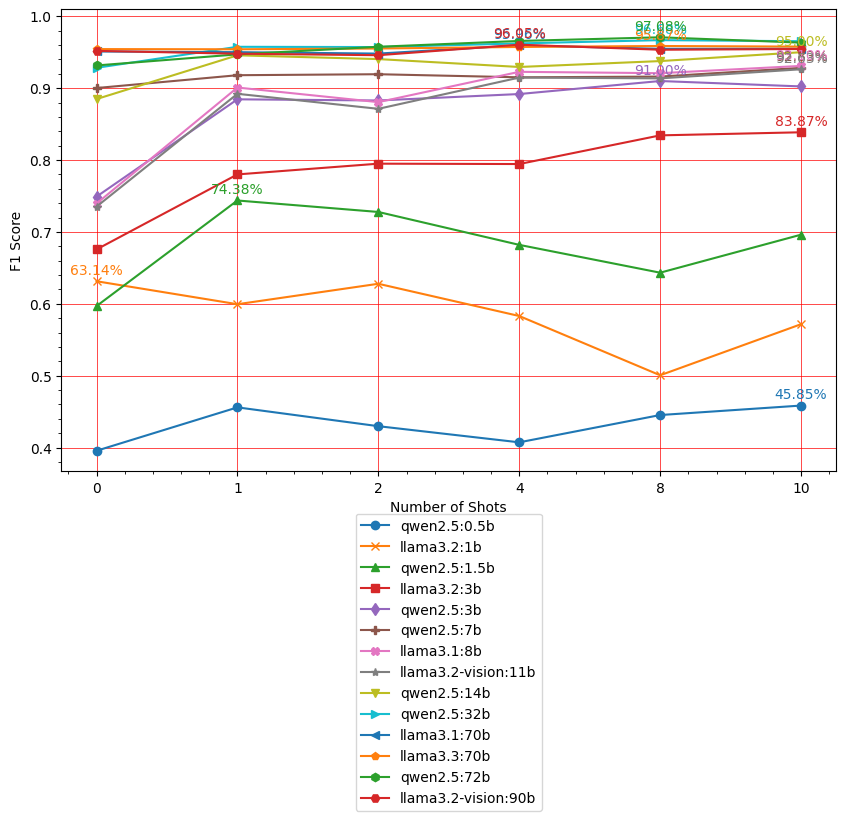

In [81]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.75),
)

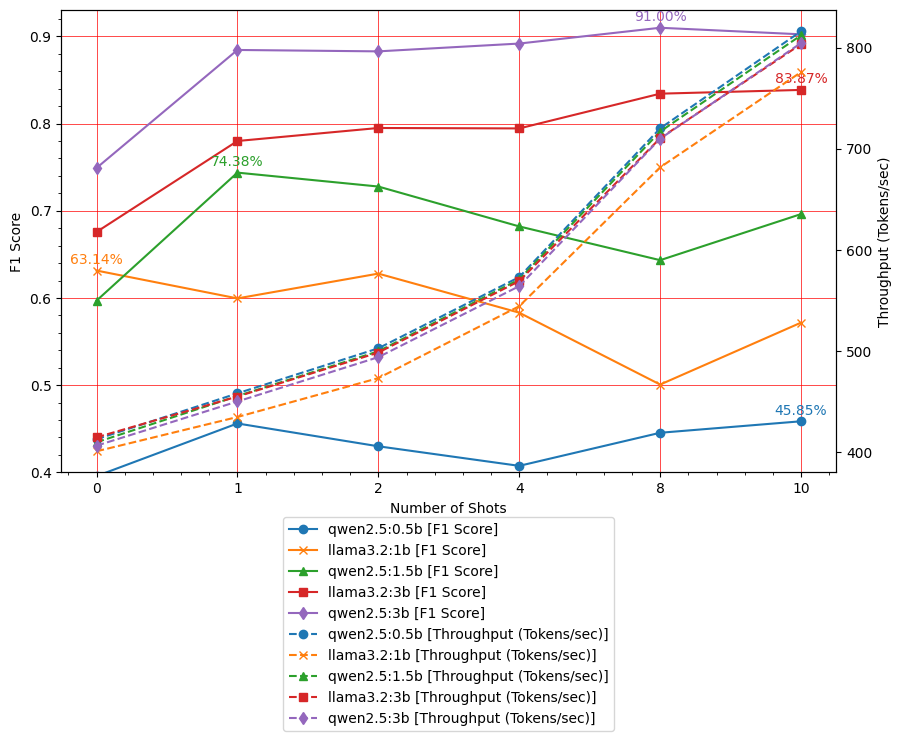

In [ ]:
plot_metrics_vs_shots(
    metrics_df,
    models[:5],
    markers[:5],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.4, 0.92),
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.575),
)

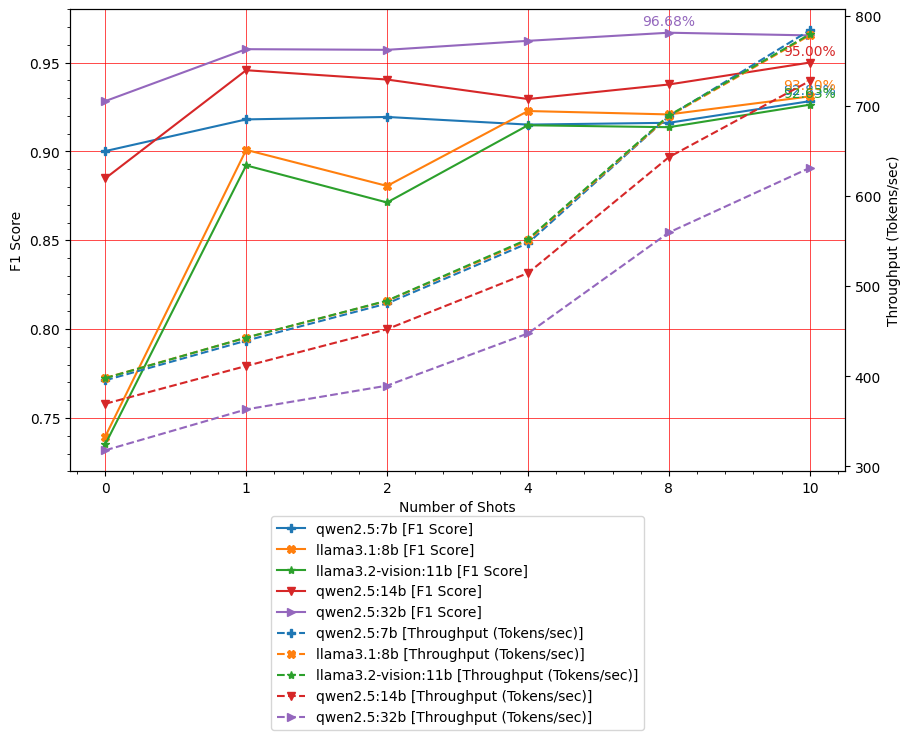

In [83]:
plot_metrics_vs_shots(
    metrics_df,
    models[5:10],
    markers[5:10],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.72, 0.97),
    # log_scales=[False, True],
    bbox_to_anchor=(0.5, -0.575),
)

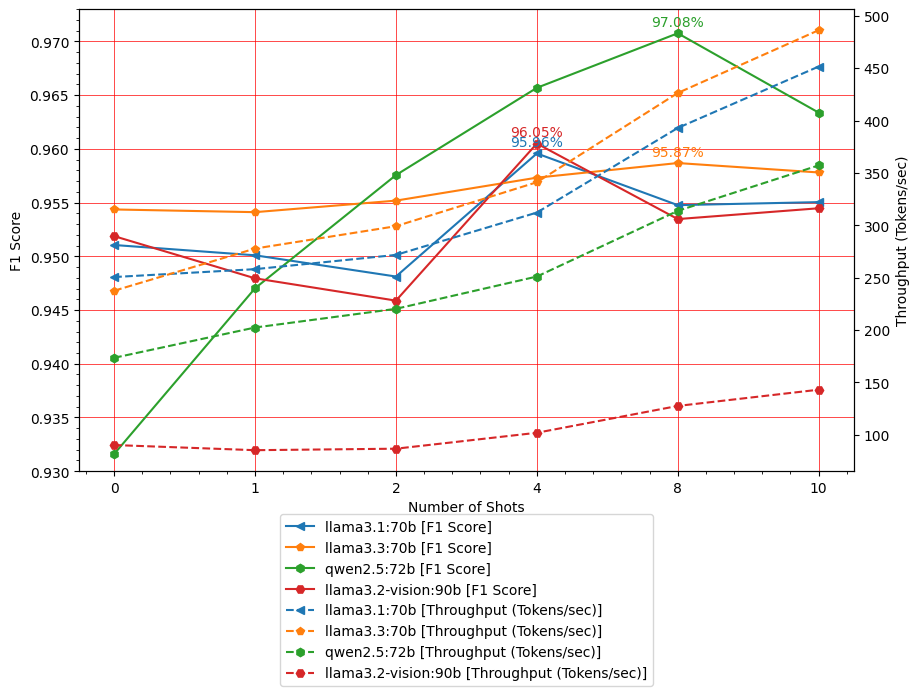

In [84]:
plot_metrics_vs_shots(
    metrics_df,
    models[10:],
    markers[10:],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    # log_scales=[True],
    ylimits=(0.93, 0.97),
    ylimits_offset=0.003,
    bbox_to_anchor=(0.5, -0.48),
)

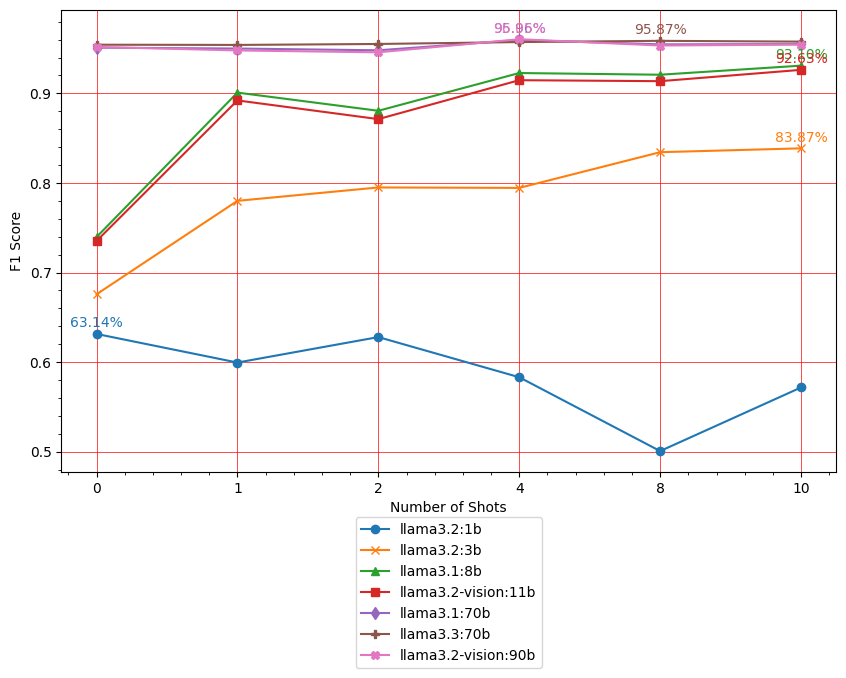

In [85]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

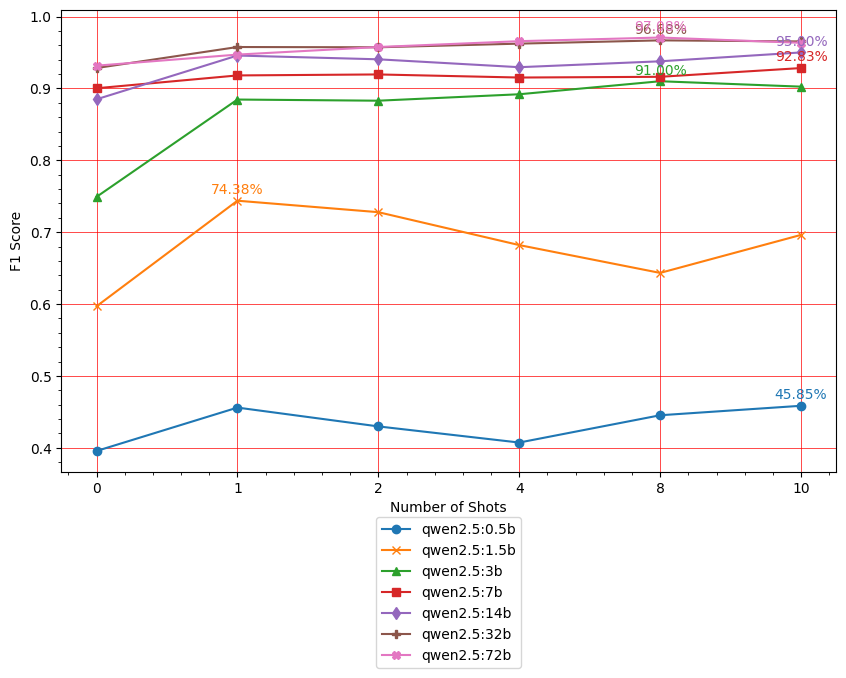

In [86]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

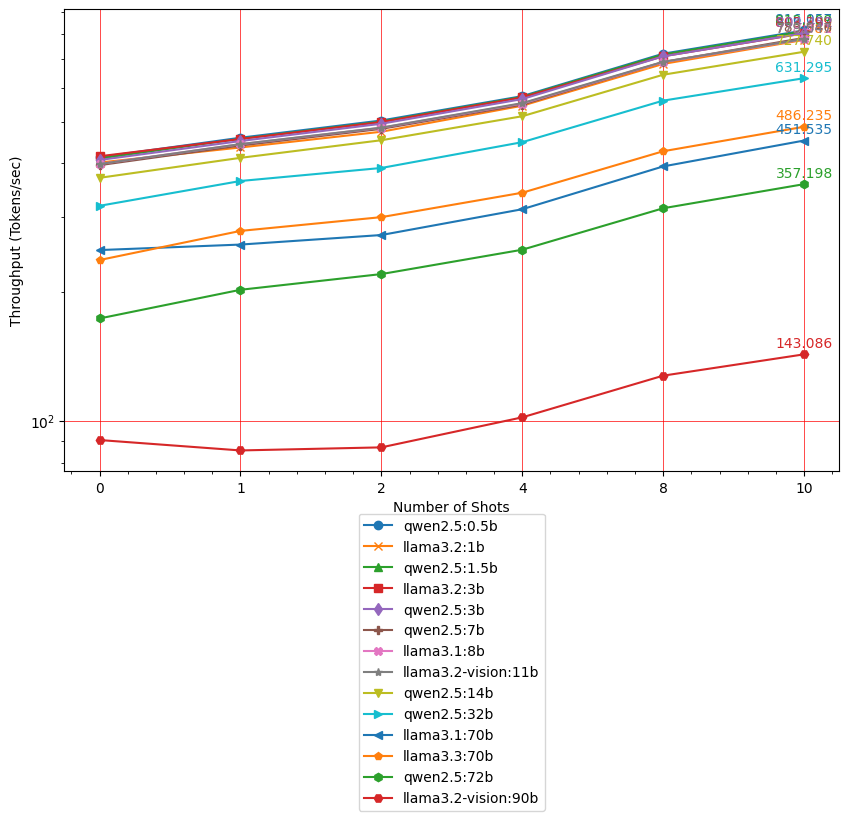

In [87]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    use_percentage=False,
)

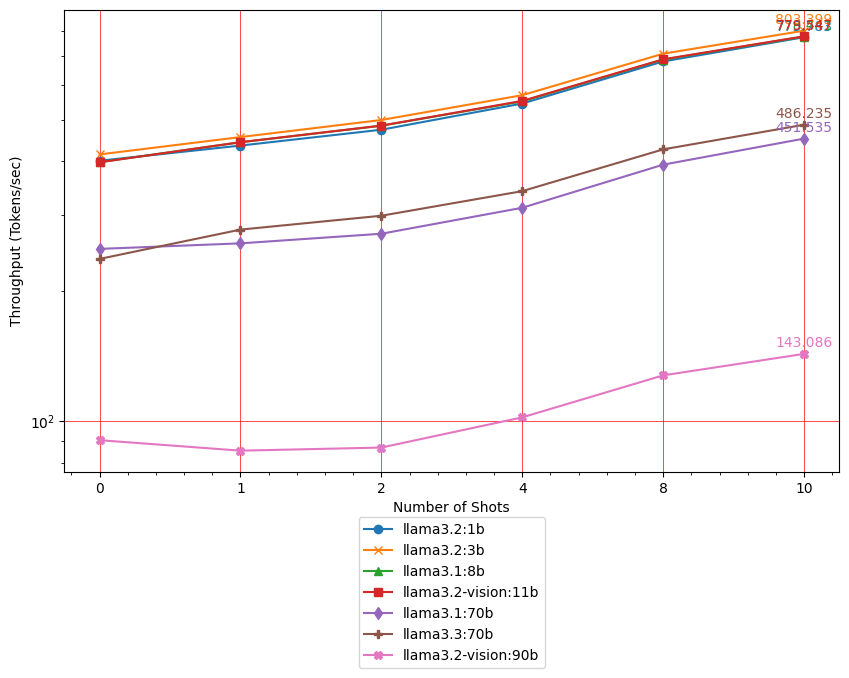

In [88]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

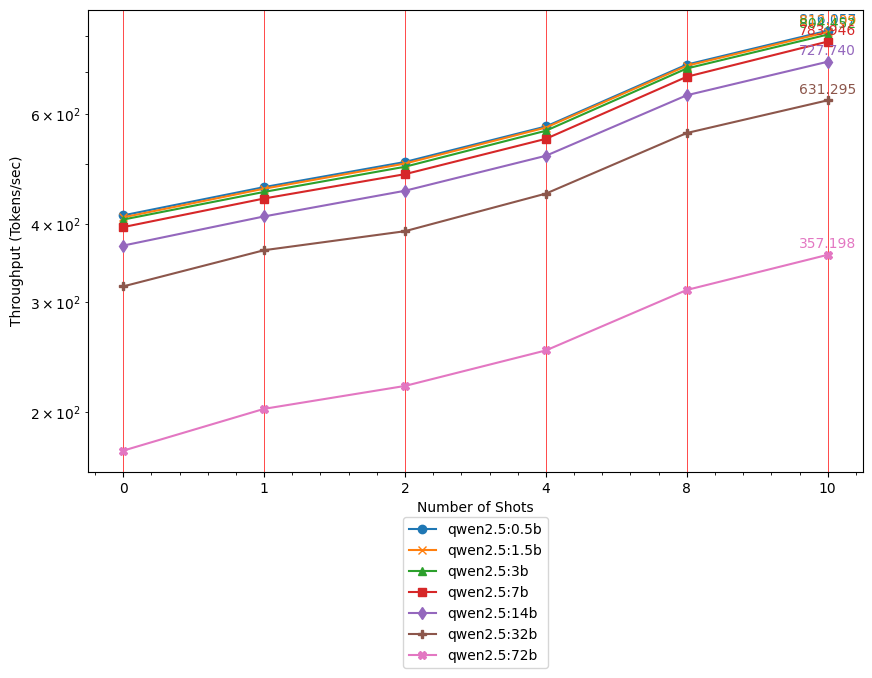

In [89]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

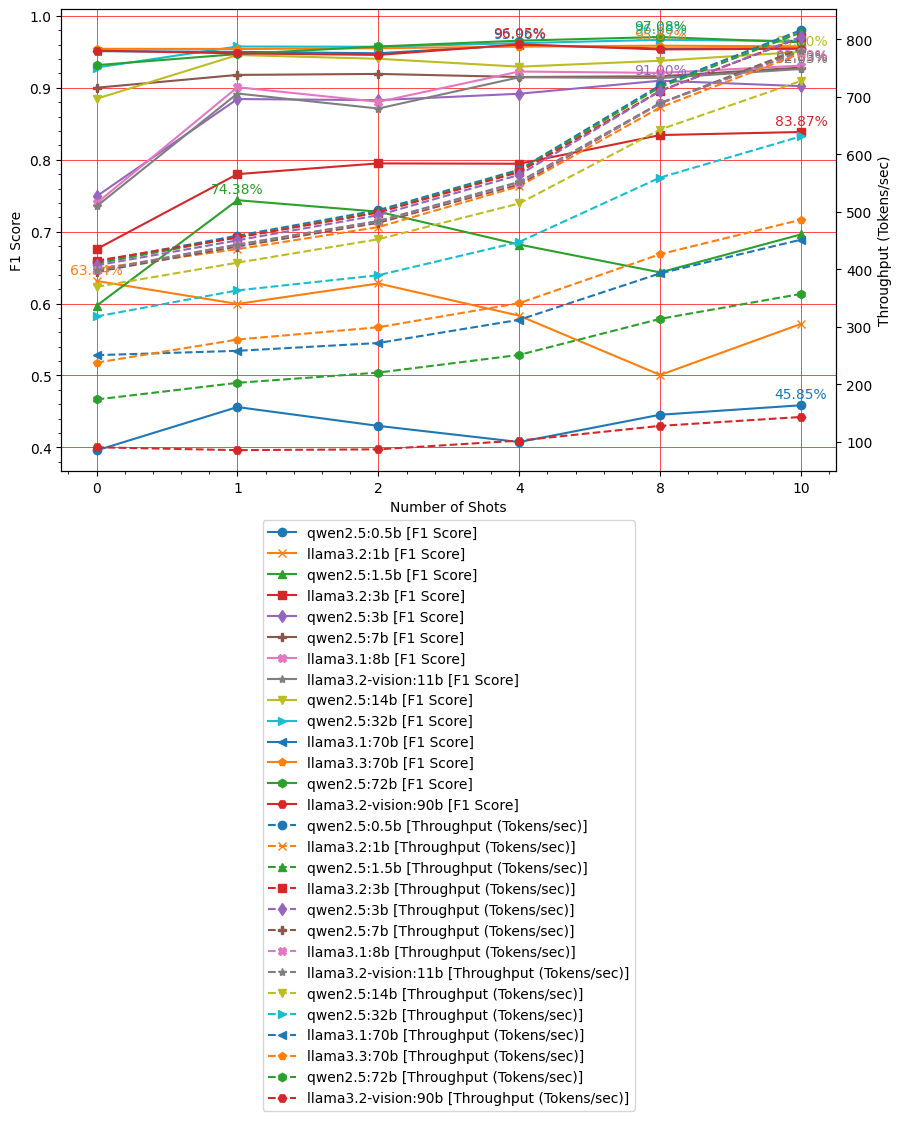

In [90]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    bbox_to_anchor=(0.5, -1.4),
)

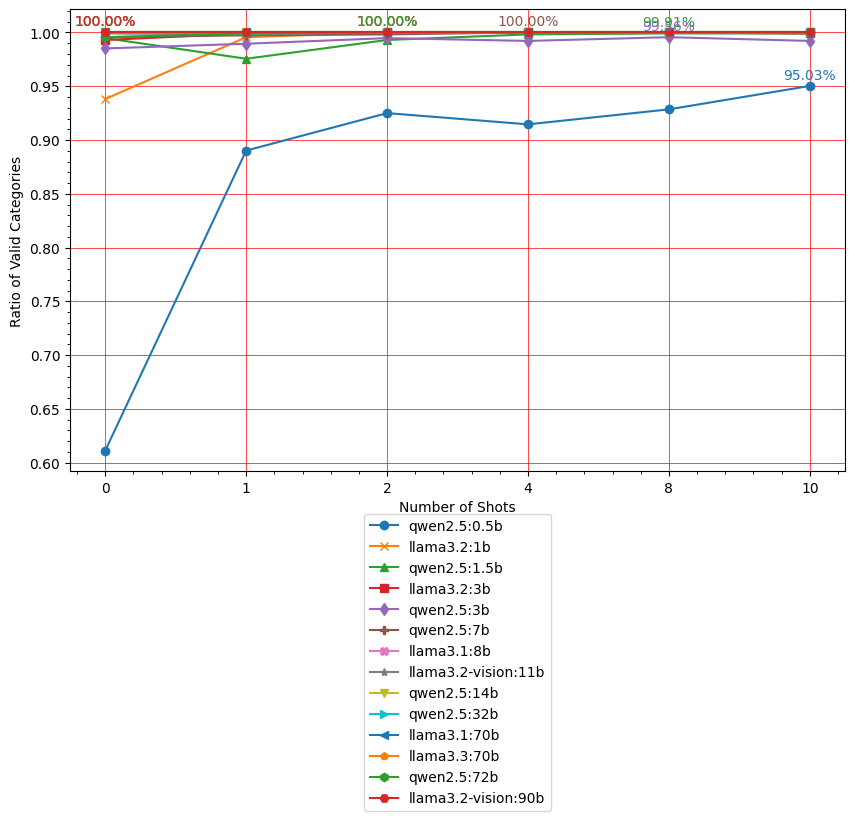

In [91]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits_offset=0.002,
)

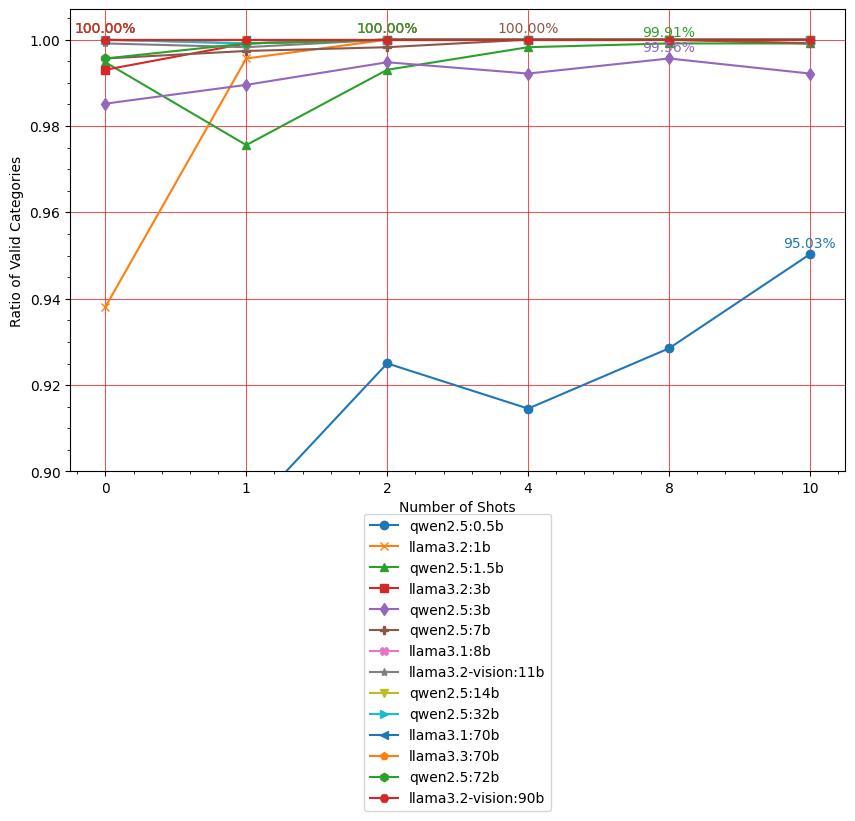

In [92]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits=[0.9, 1.005],
    ylimits_offset=0.002,
)

In [93]:
top_metrics_df = get_top_metrics_df(metrics_df)
top_metrics_df

model  shots  eval_time        f1  accuracy  f1_raw  \
5          qwen2.5:0.5b     10      2.573  0.458524  0.497820     0.0   
6           llama3.2:1b      0      2.698  0.631444  0.585004     0.0   
13         qwen2.5:1.5b      1      2.571  0.743774  0.661726     0.0   
23          llama3.2:3b     10      2.601  0.838653  0.832607     0.0   
28           qwen2.5:3b      8      2.608  0.909960  0.892764     0.0   
35           qwen2.5:7b     10      2.681  0.928289  0.922406     0.0   
41          llama3.1:8b     10      2.684  0.930978  0.931125     0.0   
47  llama3.2-vision:11b     10      2.680  0.926299  0.925894     0.0   
53          qwen2.5:14b     10      2.888  0.950025  0.946818     0.0   
58          qwen2.5:32b      8      3.315  0.966823  0.965998     0.0   
63         llama3.1:70b      4      4.724  0.959573  0.959895     0.0   
70         llama3.3:70b      8      4.322  0.958680  0.959024     0.0   
76          qwen2.5:72b      8      5.911  0.970758  0.968614     0.0   
81  llama3.2-vision:90b      4     14.460  0.960495  0.960767     0.0   

    accuracy_raw  ratio_valid_categories  total_tokens  eval_speed  
5            0.0                0.950305       2408373  816.057096  
6            0.0                0.938099       1241485  401.177080  
13           0.0                0.975588       1343988  455.753378  
23           0.0                1.000000       2396819  803.399336  
28           0.0                0.995641       2123736  709.952878  
35           0.0                0.999128       2410719  783.946380  
41           0.0                1.000000       2396467  778.440680  
47           0.0                1.000000       2396296  779.546904  
53           0.0                1.000000       2410664  727.739714  
58           0.0                1.000000       2127796  559.606870  
63           0.0                1.000000       1691379  312.153082  
70           0.0                1.000000       2113294  426.296473  
76           0.0                1.000000       2127432  313.784372  
81           0.0                1.000000       1691358  101.977376

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


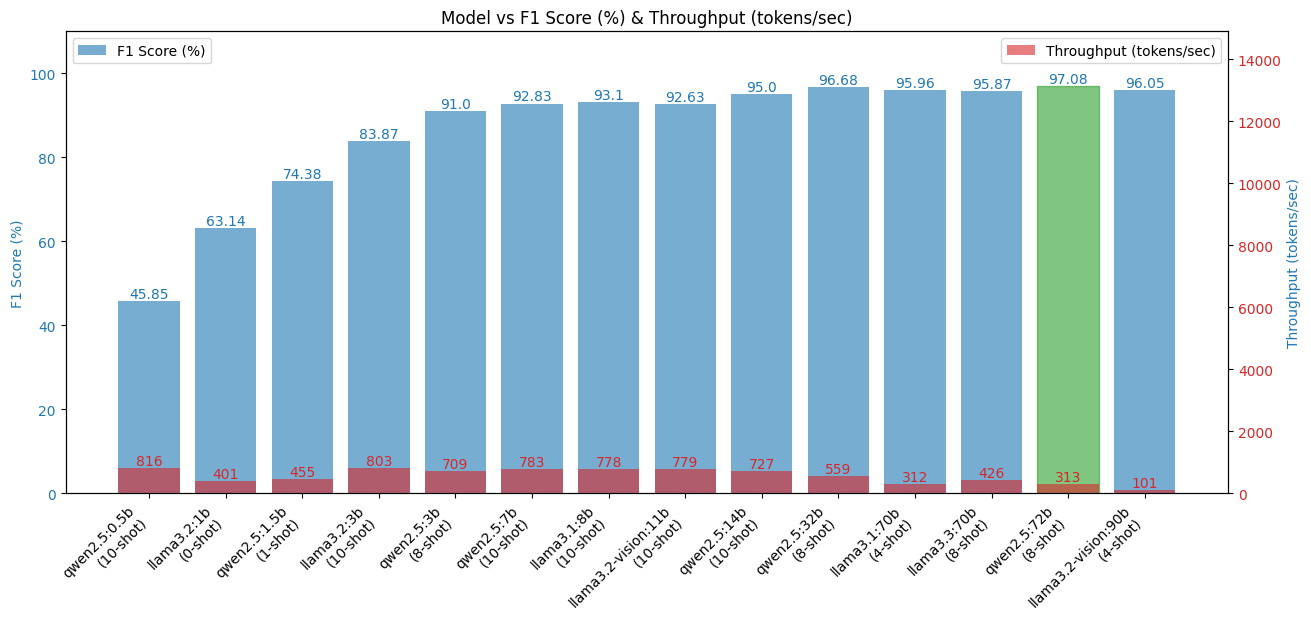

In [94]:
plot_metrics_bar_charts(top_metrics_df, second_ylim=[0, 14900])

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


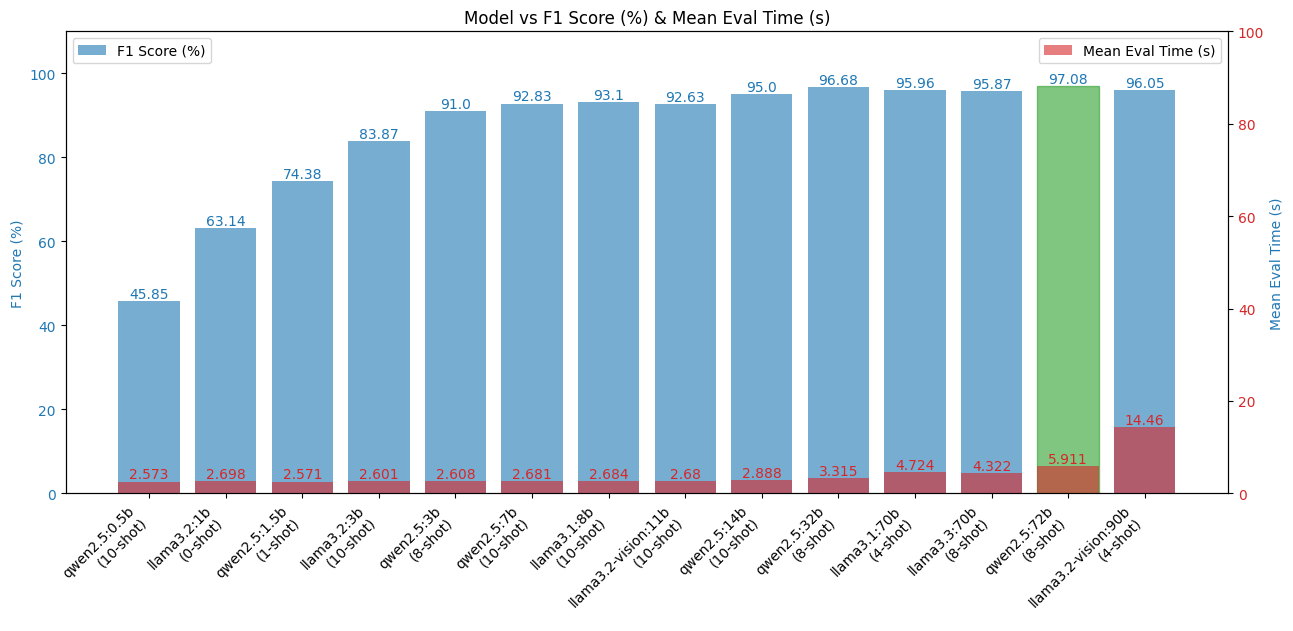

In [95]:
plot_metrics_bar_charts(
    top_metrics_df,
    second_column="eval_time",
    second_title="Mean Eval Time (s)",
    second_ylim=(0, 100),
    second_decimals=3,
)

In [96]:
ensemble_models = [
    m
    for m in all_models
    if "fp" not in m
    and top_metrics_df[top_metrics_df["model"] == m].iloc[0]["f1"] >= 0.9
]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b',
 'qwen2.5:32b',
 'llama3.1:70b',
 'llama3.3:70b',
 'qwen2.5:72b',
 'llama3.2-vision:90b']

In [97]:
ensemble_models = ensemble_models[:5]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b']

In [98]:
def majority_vote(v1, v2, v3):
    v1_ans, v2_ans, v3_ans = extract_answer(v1), extract_answer(v2), extract_answer(v3)
    if v2_ans == v3_ans and v3_ans != v1_ans:
        return v2

    return v1

In [99]:
import itertools

permutations = list(itertools.combinations(ensemble_models, 3))

for perm in permutations:
    print(perm)

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:7b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('llama3.1:8b', 'llama3.2-vision:11b', 'qwen2.5:14b')


In [100]:
for perm in permutations:
    print(perm)
    selected_rows = top_metrics_df[top_metrics_df["model"].isin(perm)]
    selected_rows = selected_rows.sort_values(by="f1", ascending=False)

    columns = []
    shots = 0
    eval_time = 0
    title = None
    for idx, row in selected_rows.iterrows():
        columns.append(
            f"{row['model']}/shots-{row['shots']:02d}({row['eval_time']:.3f})"
        )
        shots += row["shots"]
        eval_time += row["eval_time"]
        if title:
            title += f"_{row['model']}"
        else:
            title = row["model"]

    print(title, eval_time, columns)

    df_results[f"{title}/shots-{shots}({eval_time:.3f})"] = df_results.apply(
        lambda x: majority_vote(x[columns[0]], x[columns[1]], x[columns[2]]), axis=1
    )

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
llama3.1:8b_qwen2.5:7b_qwen2.5:3b 7.973000000000001 ['llama3.1:8b/shots-10(2.684)', 'qwen2.5:7b/shots-10(2.681)', 'qwen2.5:3b/shots-08(2.608)']
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b 7.969000000000001 ['qwen2.5:7b/shots-10(2.681)', 'llama3.2-vision:11b/shots-10(2.680)', 'qwen2.5:3b/shots-08(2.608)']
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b 8.177 ['qwen2.5:14b/shots-10(2.888)', 'qwen2.5:7b/shots-10(2.681)', 'qwen2.5:3b/shots-08(2.608)']
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b 7.972000000000001 ['llama3.1:8b/shots-10(2.684)', 'llama3.2-vision:11b/shots-10(2.680)', 'qwen2.5:3b/shots-08(2.608)']
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
qwen2.5:14b_llama3.1:8b_qwen2.5:3b 8.18 ['qwen2.5:14b/shots-10(2.888)', 'llama3.1:8b/shots-10(2.684)', 'qwen2.5:3b/shots-08(2.608)']
('qwen2.5:3b', 'llama3.2-vision

In [101]:
ensemble_metrics_df = get_metrics(
    df_results, -len(permutations), mean_eval_time=True, label_column="gpt-4o_label"
)
ensemble_metrics_df

llama3.1:8b_qwen2.5:7b_qwen2.5:3b/shots-28(7.973) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
llama3.1:8b_qwen2.5:7b_qwen2.5:3b/shots-28(7.973) - metrics: {'f1': 0.9451655027061134, 'accuracy': 0.942458587619878}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b/shots-28(7.969) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b/shots-28(7.969) - metrics: {'f1': 0.9425919163655921, 'accuracy': 0.9380993897122929}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b/shots-28(8.177) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b/shots-28(8.177) - metrics: {'f1': 0.9447644493877263, 'accuracy': 0.9407149084568439}
Generating prompt templates for 28 shots with Headline_Details and gpt-4o_label
llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b/shots-28(7.972) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}


model  shots  eval_time        f1  \
0            llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28      7.973  0.945166   
1    qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b     28      7.969  0.942592   
2            qwen2.5:14b_qwen2.5:7b_qwen2.5:3b     28      8.177  0.944764   
3   llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28      7.972  0.935723   
4           qwen2.5:14b_llama3.1:8b_qwen2.5:3b     28      8.180  0.948617   
5   qwen2.5:14b_llama3.2-vision:11b_qwen2.5:3b     28      8.176  0.946855   
6   llama3.1:8b_qwen2.5:7b_llama3.2-vision:11b     30      8.045  0.934560   
7           qwen2.5:14b_llama3.1:8b_qwen2.5:7b     30      8.253  0.951648   
8   qwen2.5:14b_qwen2.5:7b_llama3.2-vision:11b     30      8.249  0.952759   
9  qwen2.5:14b_llama3.1:8b_llama3.2-vision:11b     30      8.252  0.937804   

   accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0  0.942459     0.0           0.0                1.000000       2505125   
1  0.938099     0.0           0.0                0.999128       2505757   
2  0.940715     0.0           0.0                1.000000       2505927   
3  0.935484     0.0           0.0                1.000000       2505033   
4  0.946818     0.0           0.0                1.000000       2505728   
5  0.944202     0.0           0.0                1.000000       2505718   
6  0.934612     0.0           0.0                1.000000       2505062   
7  0.951177     0.0           0.0                1.000000       2505794   
8  0.952049     0.0           0.0                1.000000       2505883   
9  0.938099     0.0           0.0                1.000000       2505759   

   eval_speed  
0  273.932915  
1  274.139558  
2  267.184340  
3  273.957216  
4  267.065141  
5  267.194732  
6  271.474482  
7  264.709850  
8  264.847616  
9  264.738230

In [102]:
top_performance = {row["model"]: row["f1"] for _, row in top_metrics_df.iterrows()}
top_performance

{'qwen2.5:0.5b': 0.4585243842864188,
 'llama3.2:1b': 0.6314437393934343,
 'qwen2.5:1.5b': 0.7437736712573402,
 'llama3.2:3b': 0.8386534079171795,
 'qwen2.5:3b': 0.9099600064839988,
 'qwen2.5:7b': 0.9282894178983229,
 'llama3.1:8b': 0.9309776744587026,
 'llama3.2-vision:11b': 0.9262989671623613,
 'qwen2.5:14b': 0.9500250926638638,
 'qwen2.5:32b': 0.9668225511204042,
 'llama3.1:70b': 0.9595732310175878,
 'llama3.3:70b': 0.9586799180990596,
 'qwen2.5:72b': 0.9707583280385403,
 'llama3.2-vision:90b': 0.9604949085863371}

In [103]:
indices = []
for idx, row in ensemble_metrics_df.iterrows():
    for model in top_performance.keys():
        if row["model"].startswith(model) and row["f1"] > top_performance[model]:
            indices.append(idx)
            break

ensemble_metrics_df = ensemble_metrics_df.loc[indices]
ensemble_metrics_df

model  shots  eval_time        f1  \
0           llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28      7.973  0.945166   
1   qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b     28      7.969  0.942592   
3  llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28      7.972  0.935723   
6  llama3.1:8b_qwen2.5:7b_llama3.2-vision:11b     30      8.045  0.934560   
7          qwen2.5:14b_llama3.1:8b_qwen2.5:7b     30      8.253  0.951648   
8  qwen2.5:14b_qwen2.5:7b_llama3.2-vision:11b     30      8.249  0.952759   

   accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0  0.942459     0.0           0.0                1.000000       2505125   
1  0.938099     0.0           0.0                0.999128       2505757   
3  0.935484     0.0           0.0                1.000000       2505033   
6  0.934612     0.0           0.0                1.000000       2505062   
7  0.951177     0.0           0.0                1.000000       2505794   
8  0.952049     0.0           0.0                1.000000       2505883   

   eval_speed  
0  273.932915  
1  274.139558  
3  273.957216  
6  271.474482  
7  264.709850  
8  264.847616

In [104]:
# Concatenate vertically
top_metrics_df = pd.concat([top_metrics_df, ensemble_metrics_df], axis=0).reset_index(
    drop=True
)
top_metrics_df

model  shots  eval_time        f1  \
0                                 qwen2.5:0.5b     10      2.573  0.458524   
1                                  llama3.2:1b      0      2.698  0.631444   
2                                 qwen2.5:1.5b      1      2.571  0.743774   
3                                  llama3.2:3b     10      2.601  0.838653   
4                                   qwen2.5:3b      8      2.608  0.909960   
5                                   qwen2.5:7b     10      2.681  0.928289   
6                                  llama3.1:8b     10      2.684  0.930978   
7                          llama3.2-vision:11b     10      2.680  0.926299   
8                                  qwen2.5:14b     10      2.888  0.950025   
9                                  qwen2.5:32b      8      3.315  0.966823   
10                                llama3.1:70b      4      4.724  0.959573   
11                                llama3.3:70b      8      4.322  0.958680   
12                                 qwen2.5:72b      8      5.911  0.970758   
13                         llama3.2-vision:90b      4     14.460  0.960495   
14           llama3.1:8b_qwen2.5:7b_qwen2.5:3b     28      7.973  0.945166   
15   qwen2.5:7b_llama3.2-vision:11b_qwen2.5:3b     28      7.969  0.942592   
16  llama3.1:8b_llama3.2-vision:11b_qwen2.5:3b     28      7.972  0.935723   
17  llama3.1:8b_qwen2.5:7b_llama3.2-vision:11b     30      8.045  0.934560   
18          qwen2.5:14b_llama3.1:8b_qwen2.5:7b     30      8.253  0.951648   
19  qwen2.5:14b_qwen2.5:7b_llama3.2-vision:11b     30      8.249  0.952759   

    accuracy  f1_raw  accuracy_raw  ratio_valid_categories  total_tokens  \
0   0.497820     0.0           0.0                0.950305       2408373   
1   0.585004     0.0           0.0                0.938099       1241485   
2   0.661726     0.0           0.0                0.975588       1343988   
3   0.832607     0.0           0.0                1.000000       2396819   
4   0.892764     0.0           0.0                0.995641       2123736   
5   0.922406     0.0           0.0                0.999128       2410719   
6   0.931125     0.0           0.0                1.000000       2396467   
7   0.925894     0.0           0.0                1.000000       2396296   
8   0.946818     0.0           0.0                1.000000       2410664   
9   0.965998     0.0           0.0                1.000000       2127796   
10  0.959895     0.0           0.0                1.000000       1691379   
11  0.959024     0.0           0.0                1.000000       2113294   
12  0.968614     0.0           0.0                1.000000       2127432   
13  0.960767     0.0           0.0                1.000000       1691358   
14  0.942459     0.0           0.0                1.000000       2505125   
15  0.938099     0.0           0.0                0.999128       2505757   
16  0.935484     0.0           0.0                1.000000       2505033   
17  0.934612     0.0           0.0                1.000000       2505062   
18  0.951177     0.0           0.0                1.000000       2505794   
19  0.952049     0.0           0.0                1.000000       2505883   

    eval_speed  
0   816.057096  
1   401.177080  
2   455.753378  
3   803.399336  
4   709.952878  
5   783.946380  
6   778.440680  
7   779.546904  
8   727.739714  
9   559.606870  
10  312.153082  
11  426.296473  
12  313.784372  
13  101.977376  
14  273.932915  
15  274.139558  
16  273.957216  
17  271.474482  
18  264.709850  
19  264.847616

In [105]:
best_top_metrics_df = top_metrics_df[top_metrics_df["f1"] >= 0.9]

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


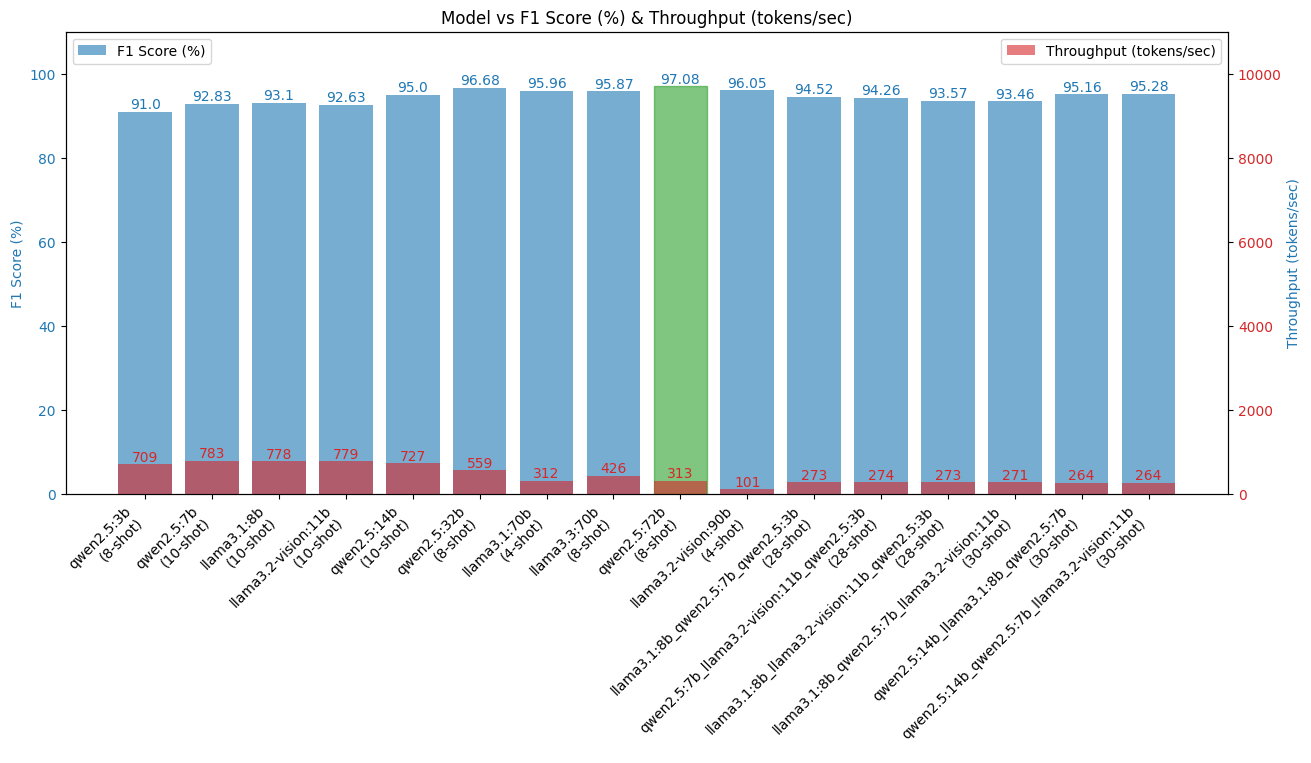

In [106]:
plot_metrics_bar_charts(best_top_metrics_df, second_ylim=[0, 11000])

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


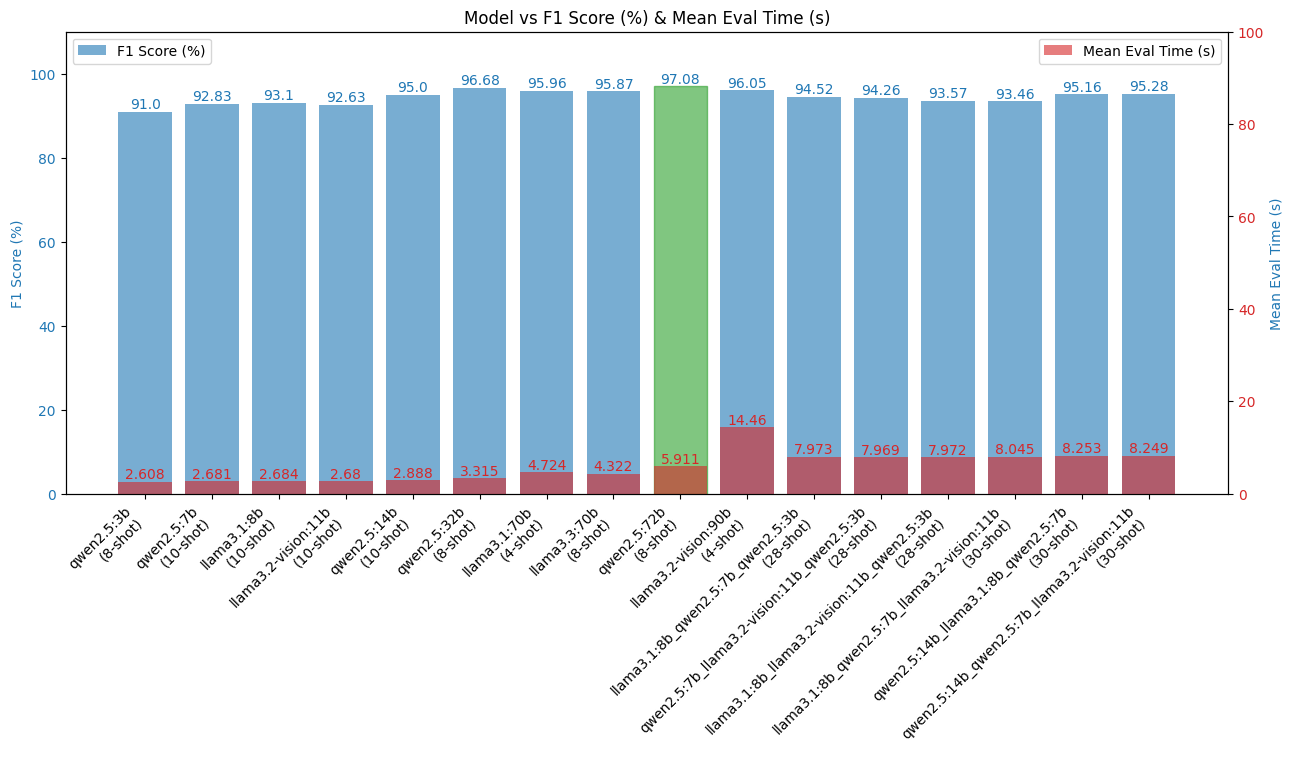

In [107]:
plot_metrics_bar_charts(
    best_top_metrics_df,
    second_column="eval_time",
    second_title="Mean Eval Time (s)",
    second_ylim=(0, 100),
    second_decimals=3,
)

In [108]:
top_metrics_df.describe()

shots  eval_time         f1   accuracy  f1_raw  accuracy_raw  \
count  20.000000  20.000000  20.000000  20.000000    20.0          20.0   
mean   13.750000   5.258850   0.889836   0.883217     0.0           0.0   
std    10.661663   3.231458   0.131805   0.136093     0.0           0.0   
min     0.000000   2.571000   0.458524   0.497820     0.0           0.0   
25%     8.000000   2.680750   0.922214   0.914996     0.0           0.0   
50%    10.000000   3.818500   0.939157   0.936792     0.0           0.0   
75%    28.000000   7.972250   0.954239   0.953793     0.0           0.0   
max    30.000000  14.460000   0.970758   0.968614     0.0           0.0   

       ratio_valid_categories  total_tokens  eval_speed  
count               20.000000  2.000000e+01   20.000000  
mean                 0.992895  2.195623e+06  479.644663  
std                  0.017634  3.973724e+05  238.536496  
min                  0.938099  1.241485e+06  101.977376  
25%                  0.999128  2.121126e+06  273.951140  
50%                  1.000000  2.396643e+06  413.736777  
75%                  1.000000  2.505040e+06  740.414955  
max                  1.000000  2.505883e+06  816.057096

In [109]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)
top_metrics_df.to_csv(results_path.replace(".csv", "_top_metrics.csv"), index=False)

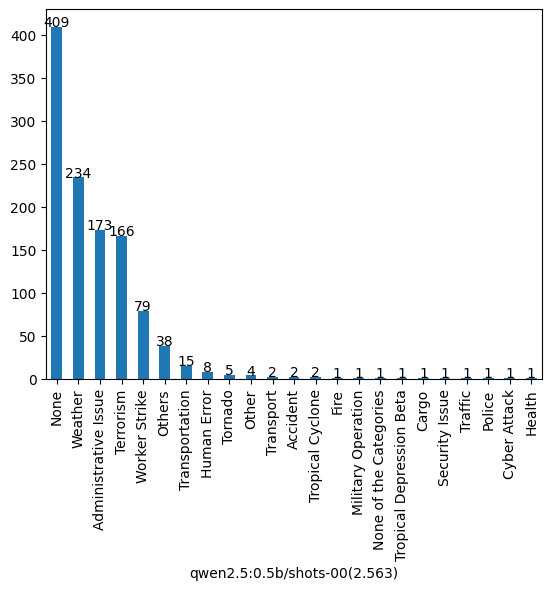

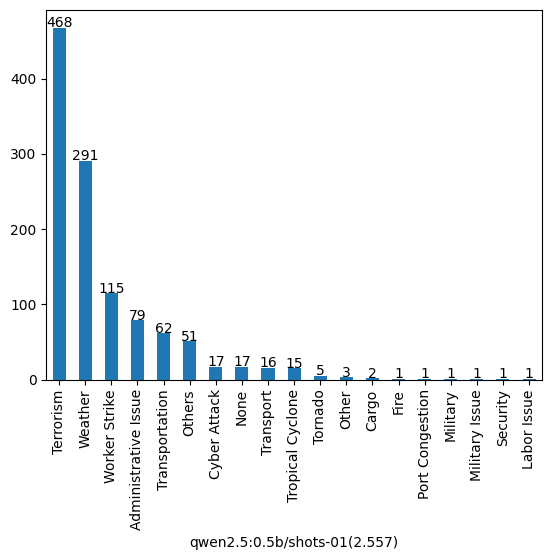

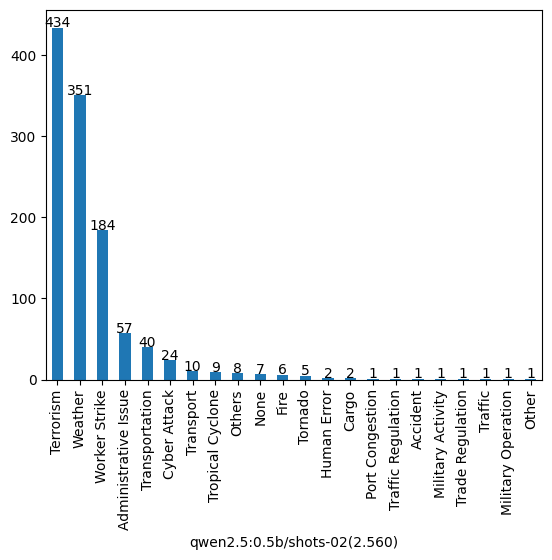

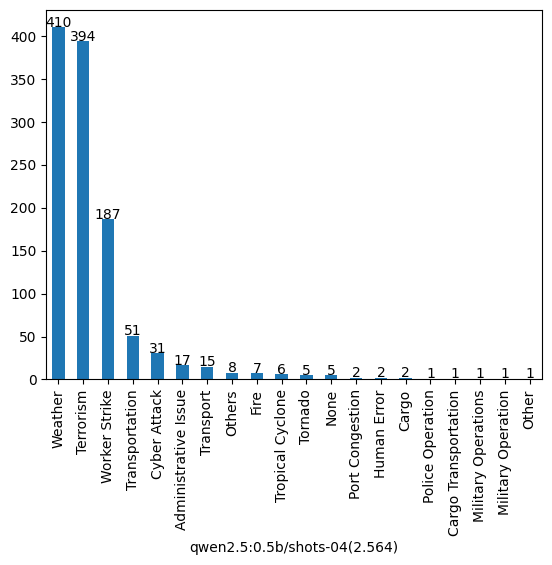

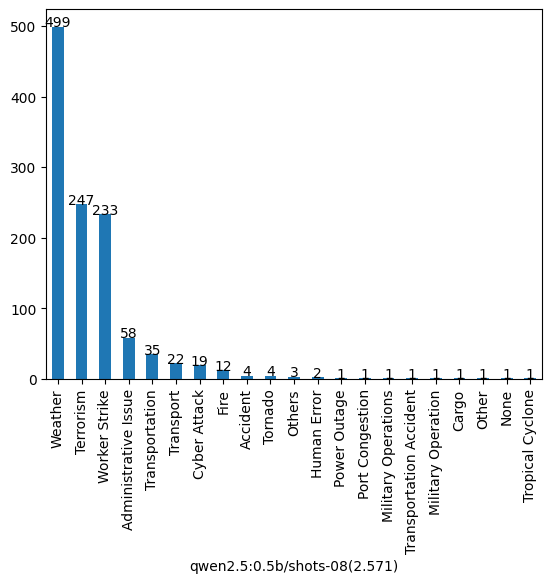

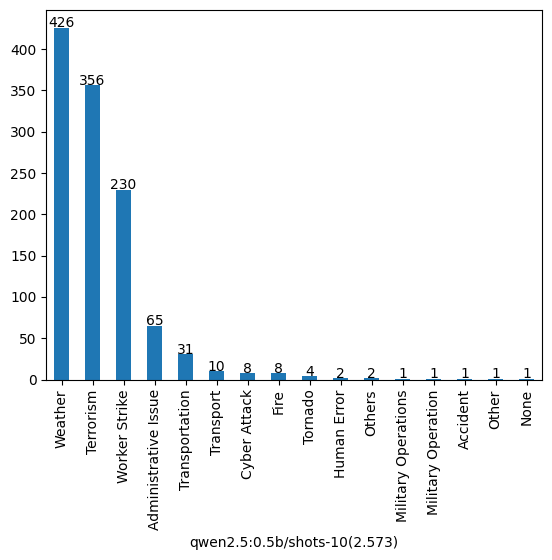

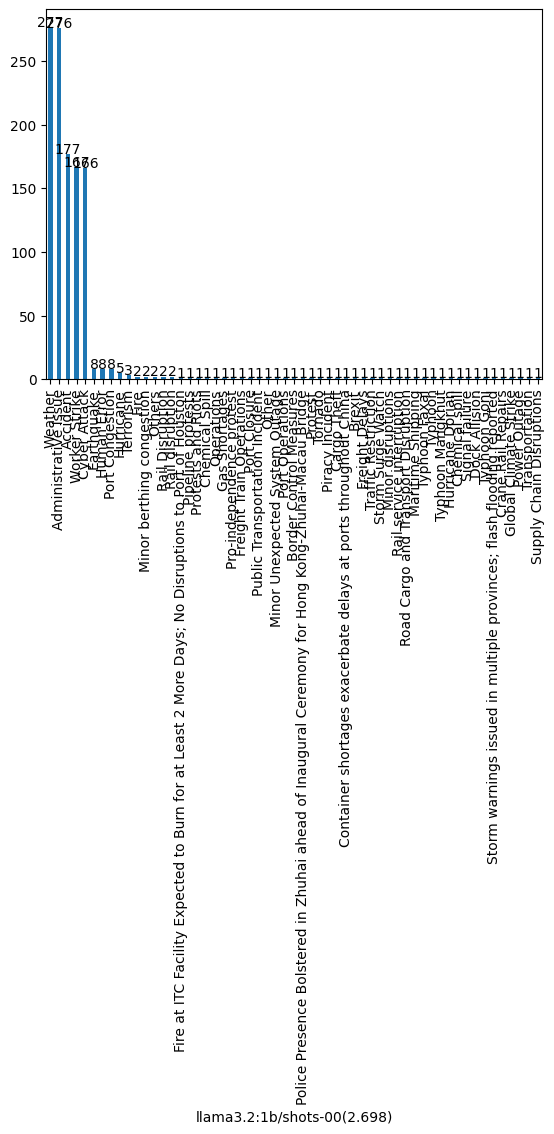

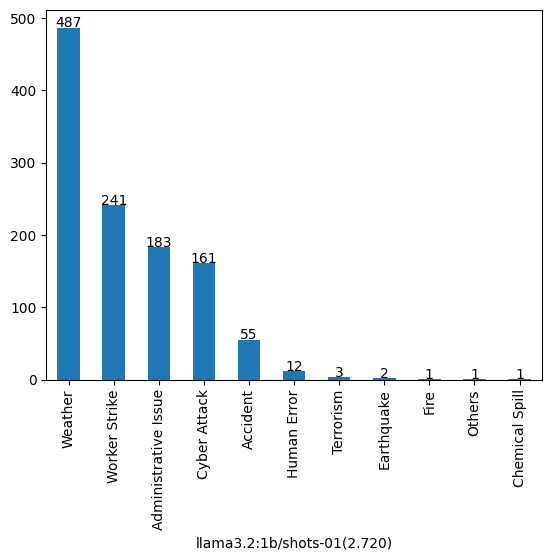

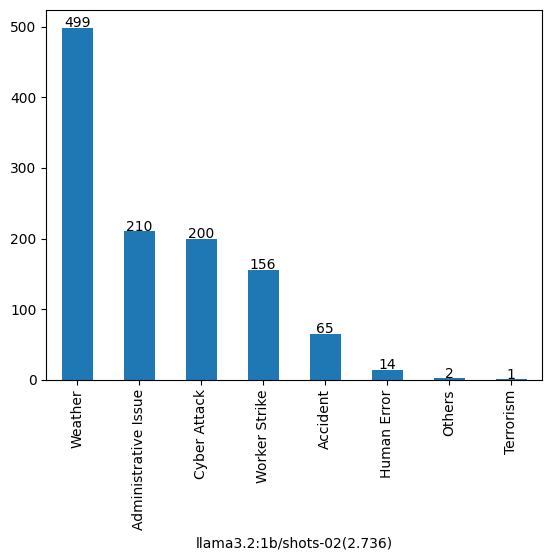

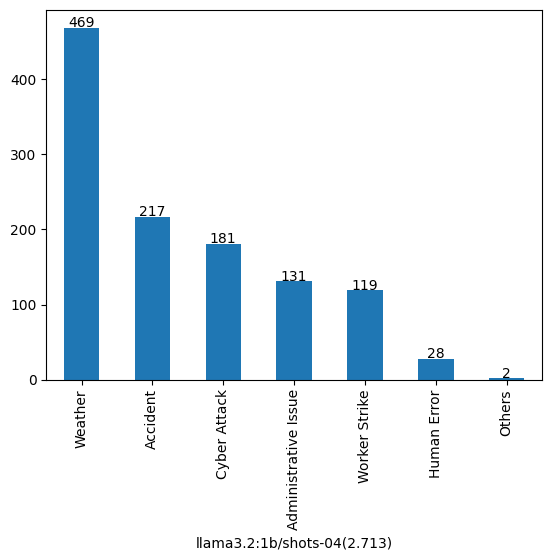

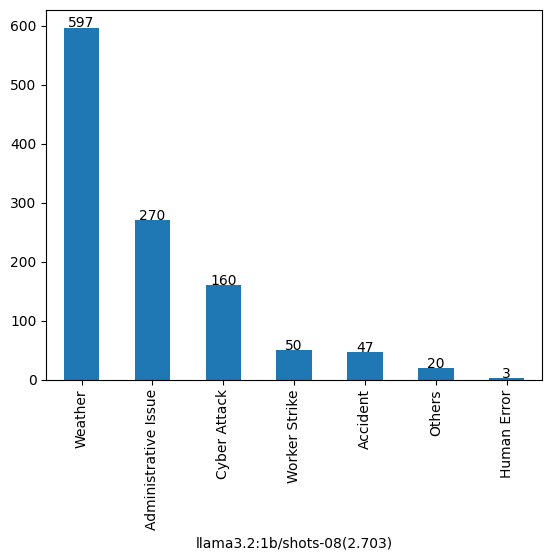

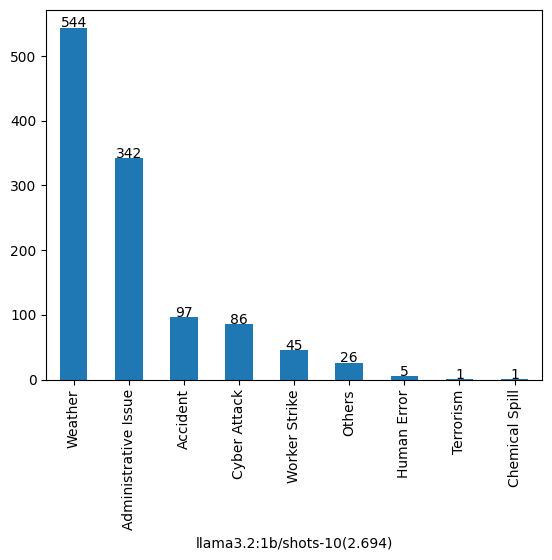

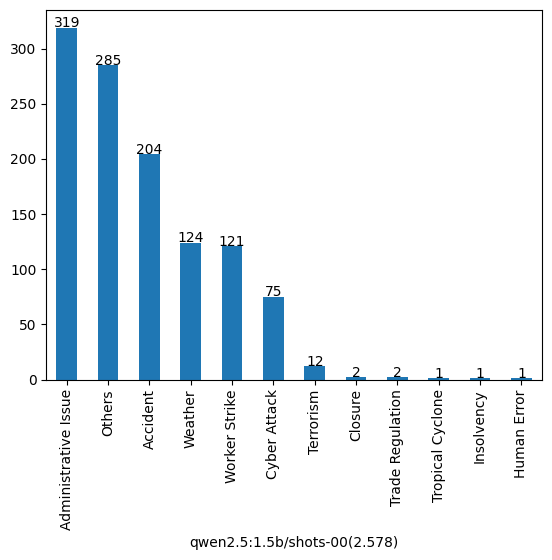

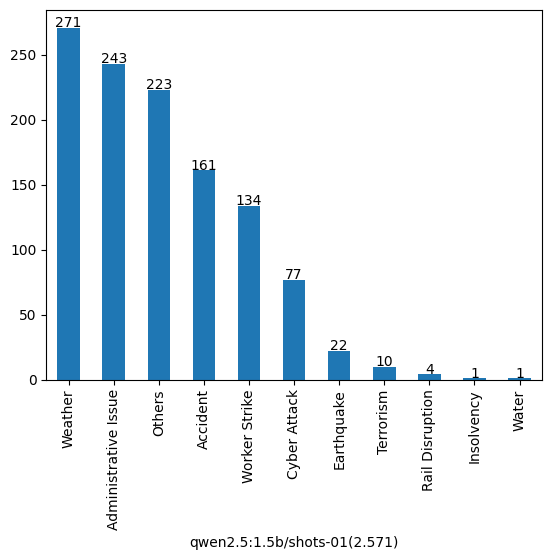

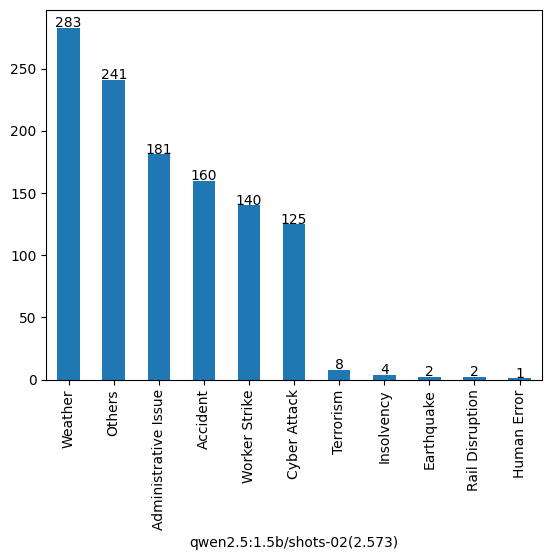

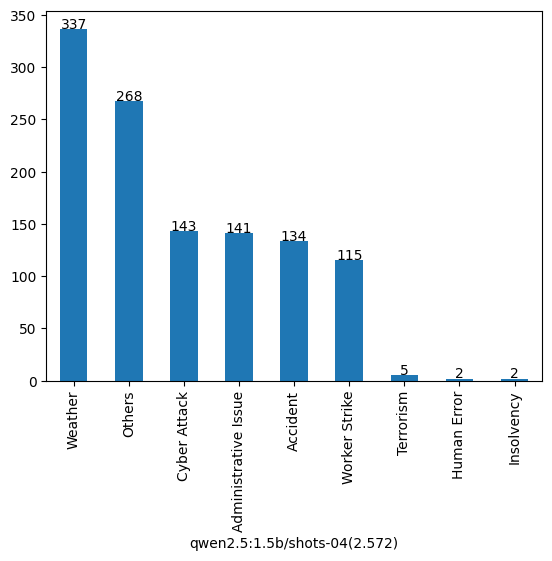

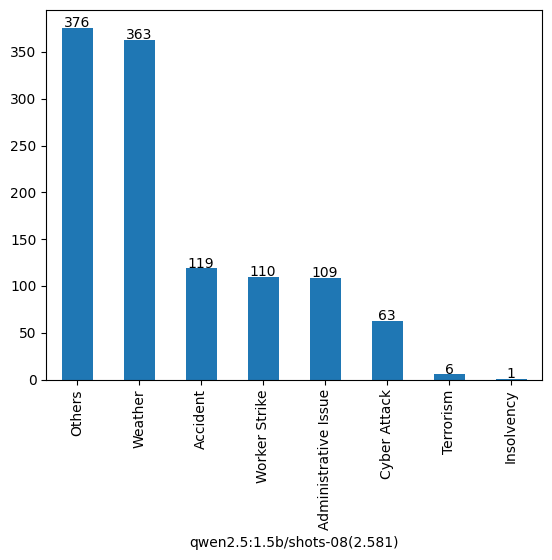

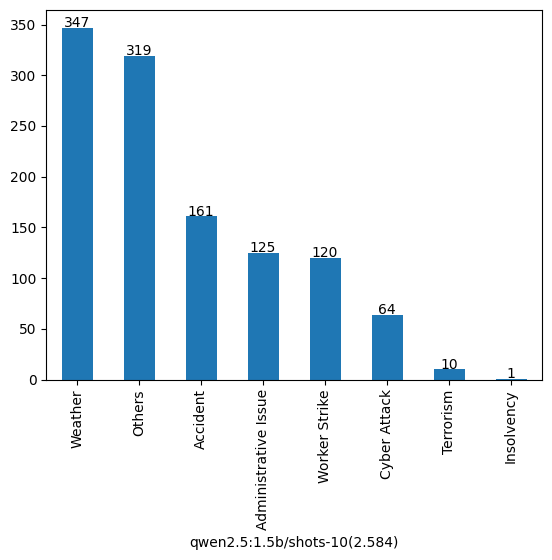

category not in json: {}


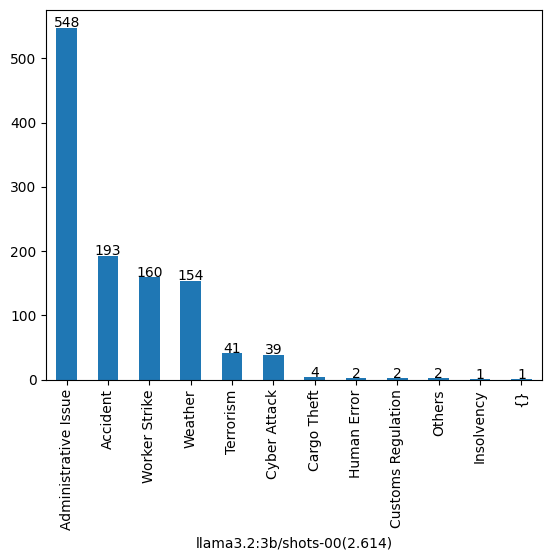

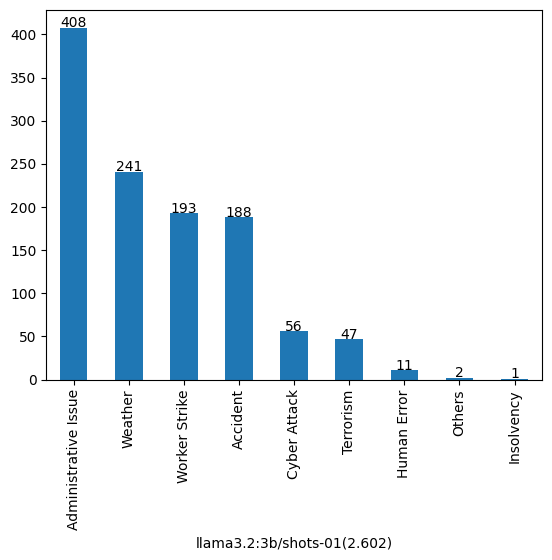

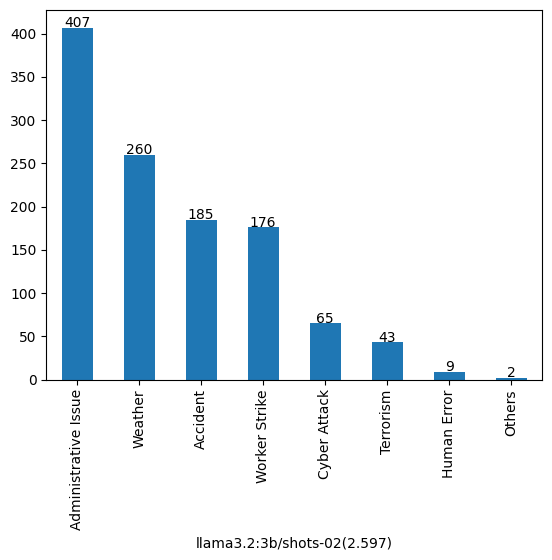

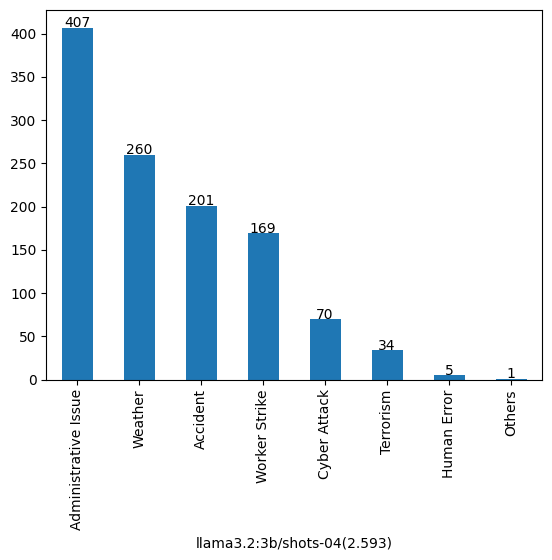

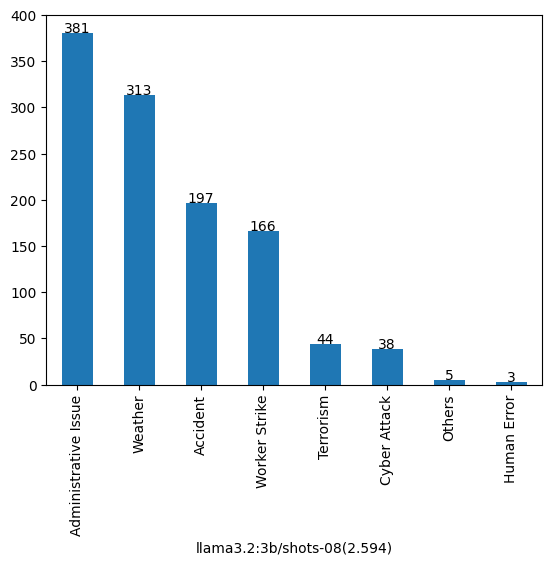

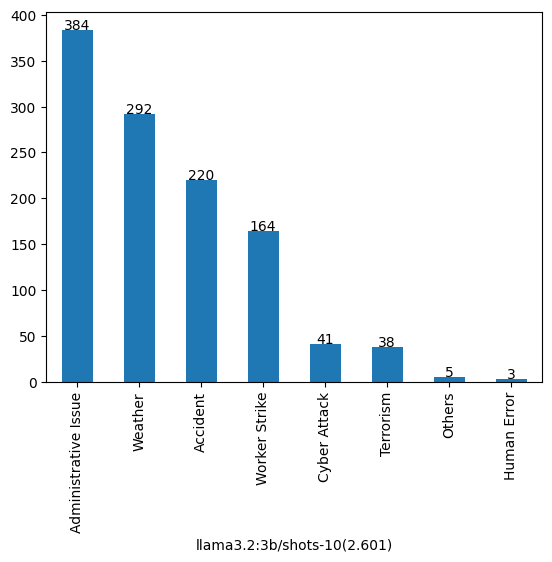

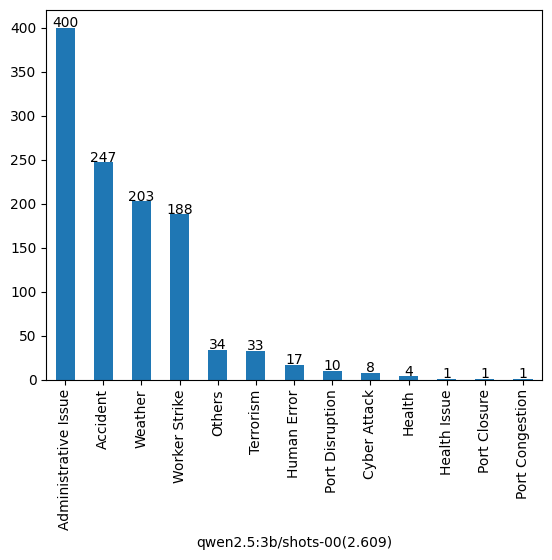

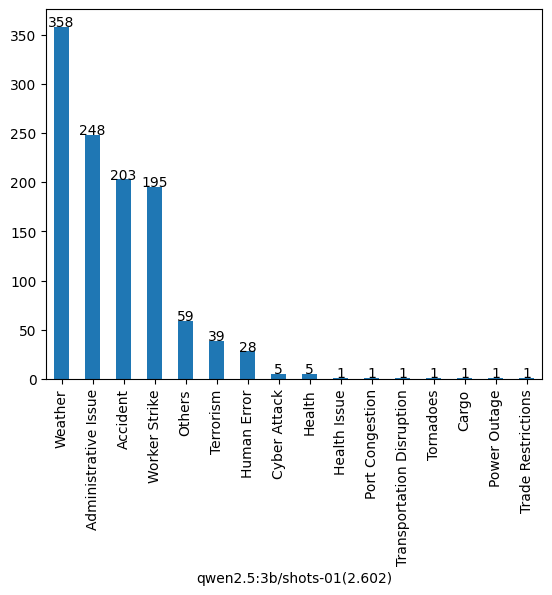

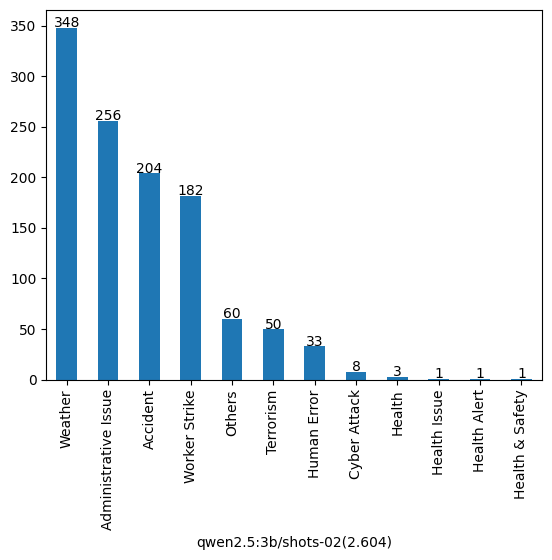

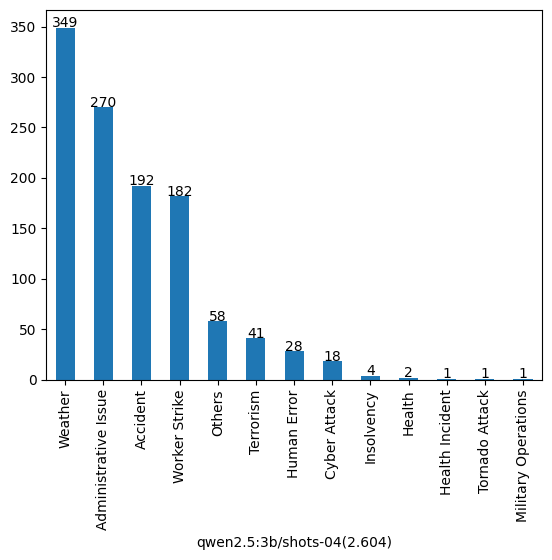

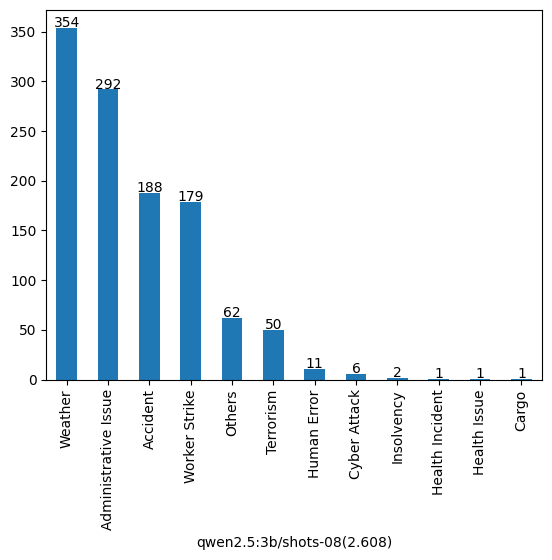

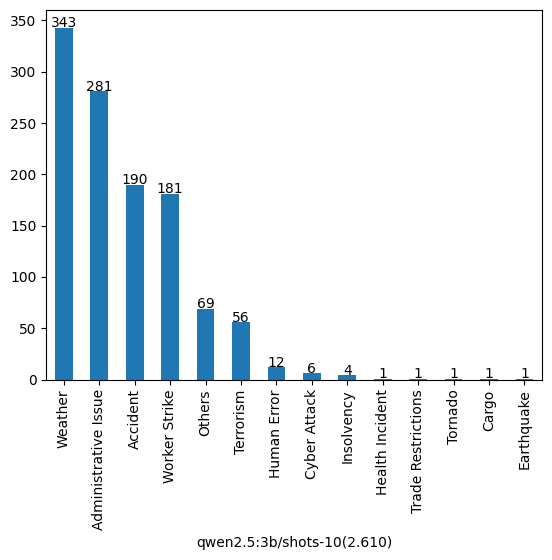

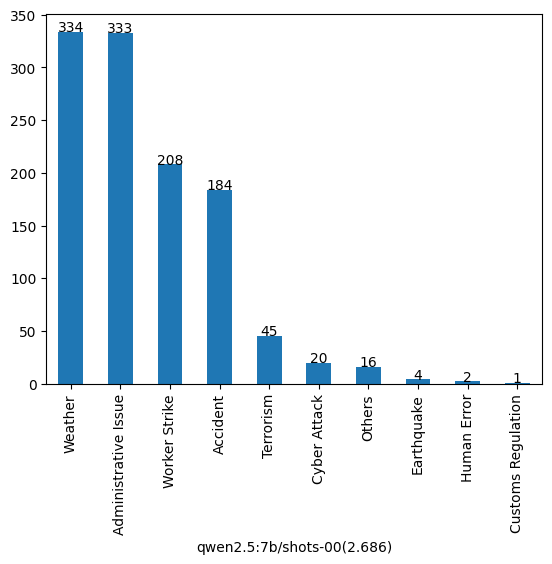

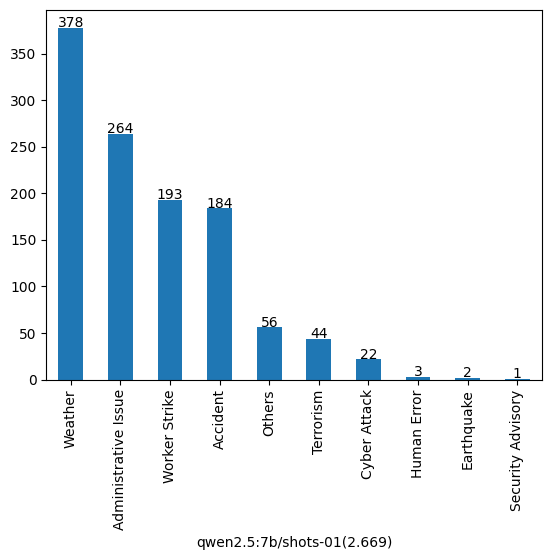

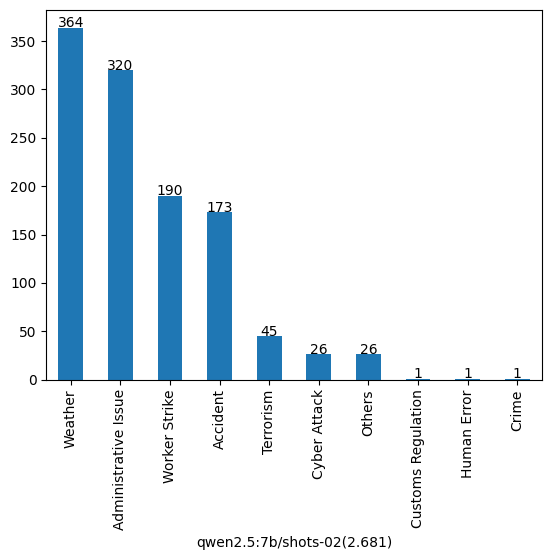

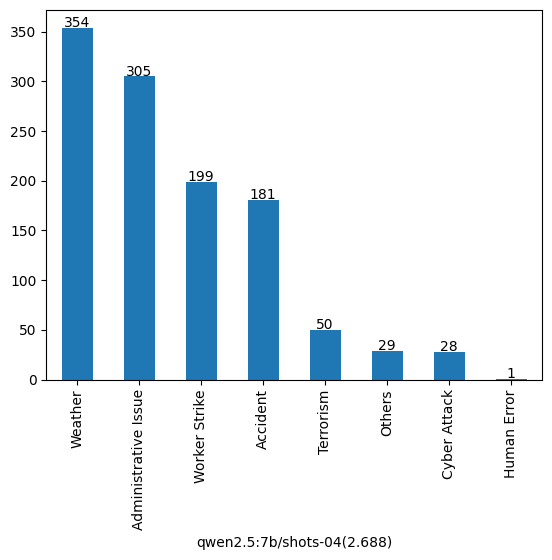

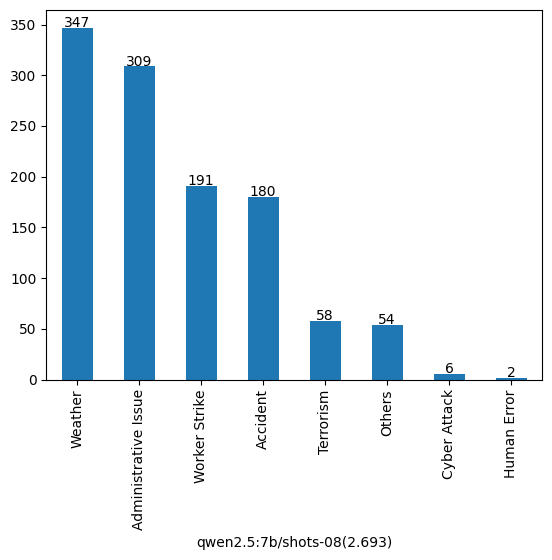

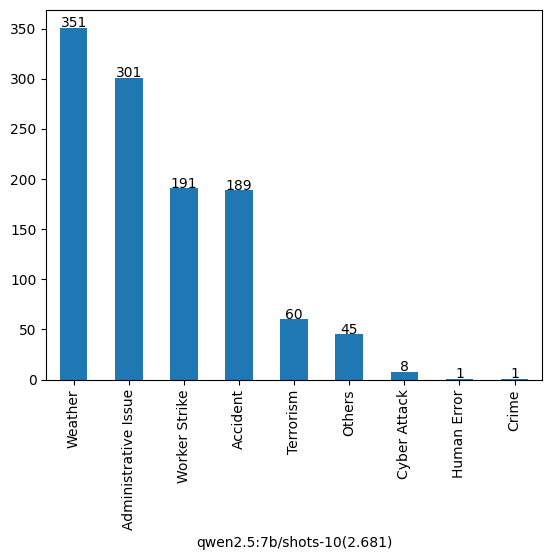

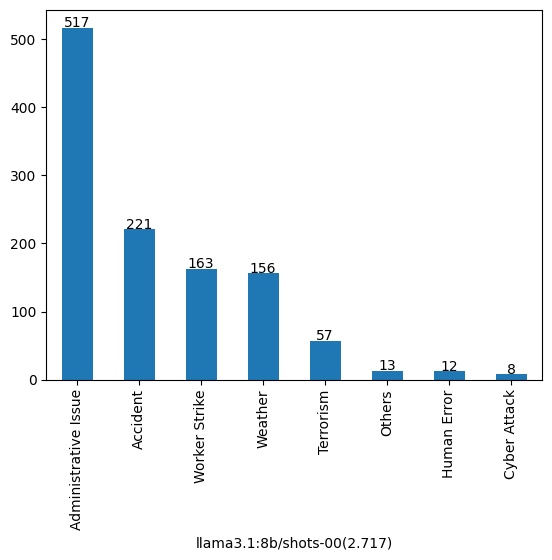

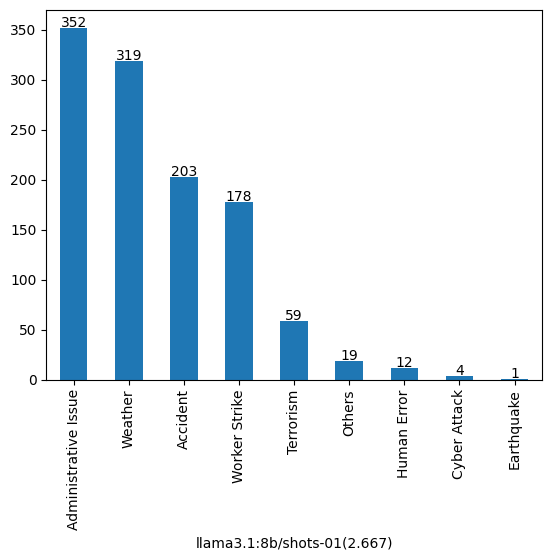

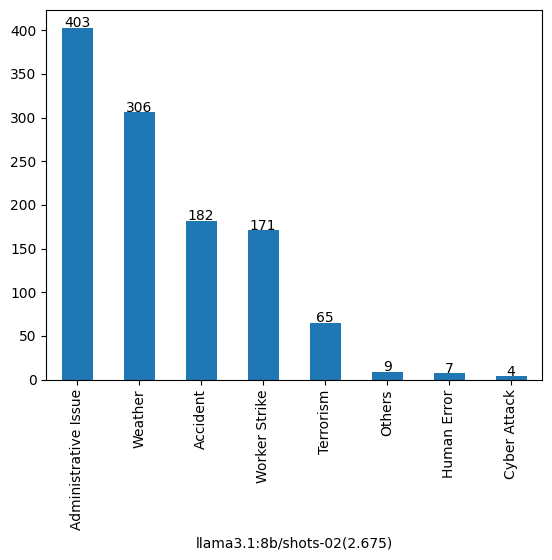

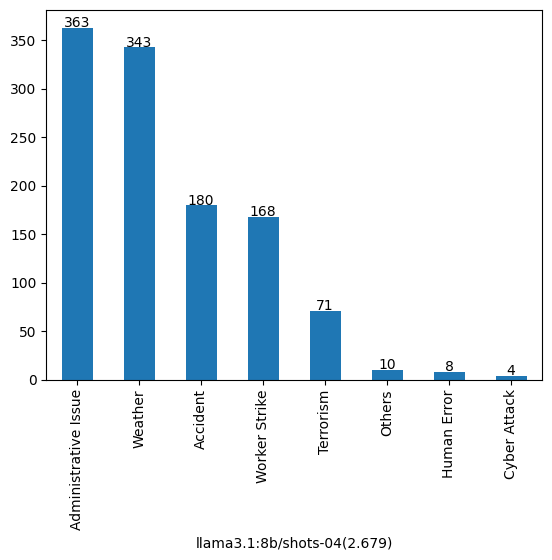

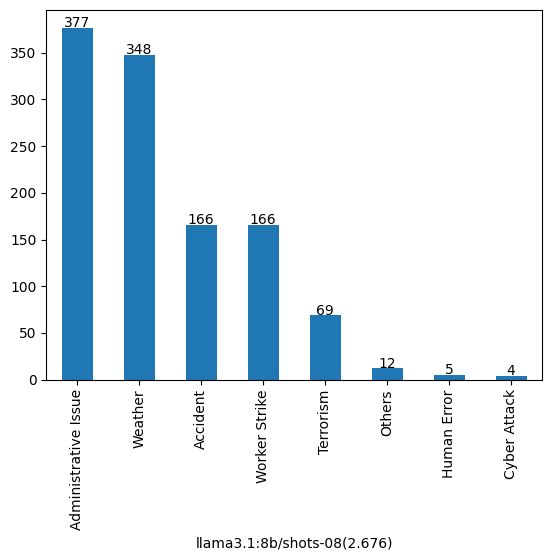

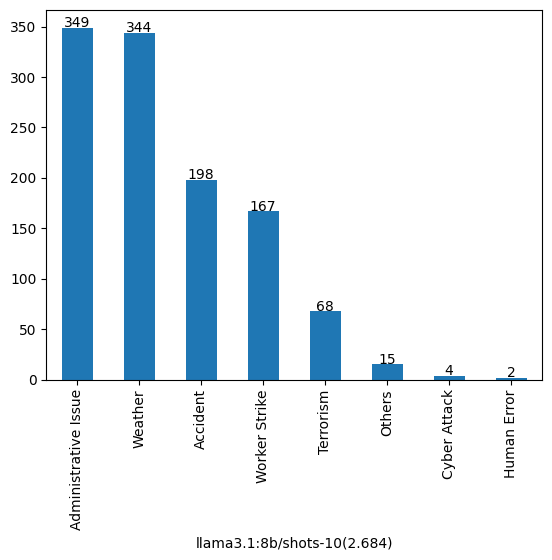

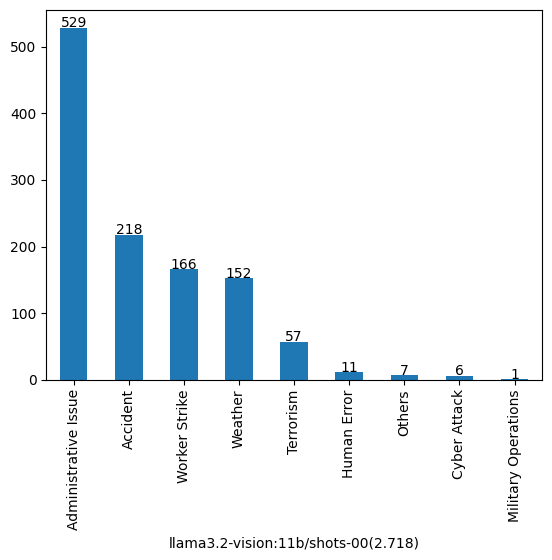

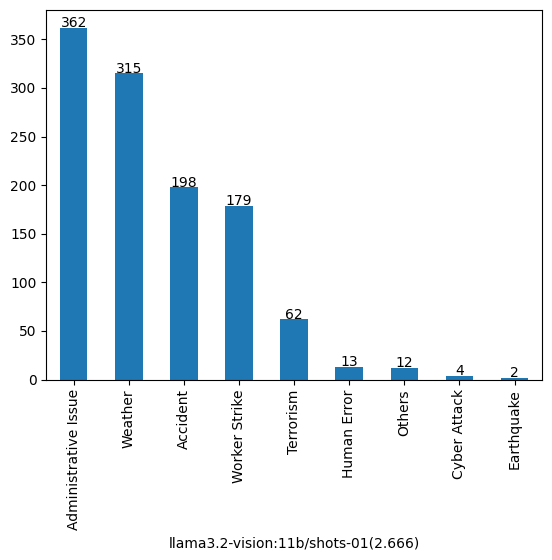

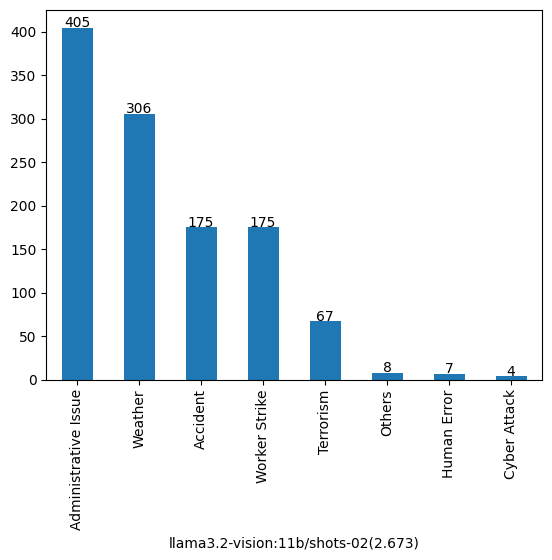

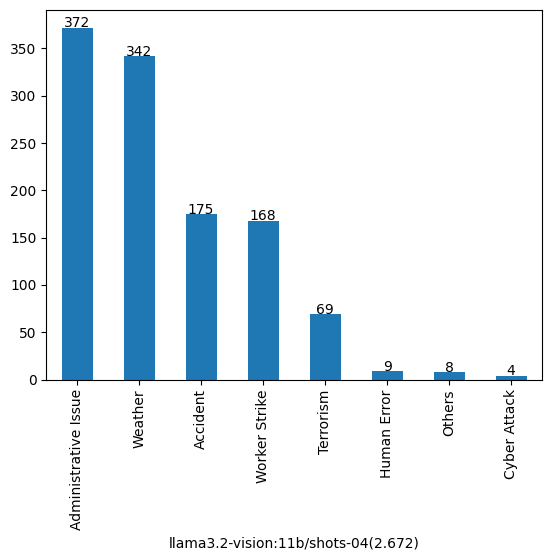

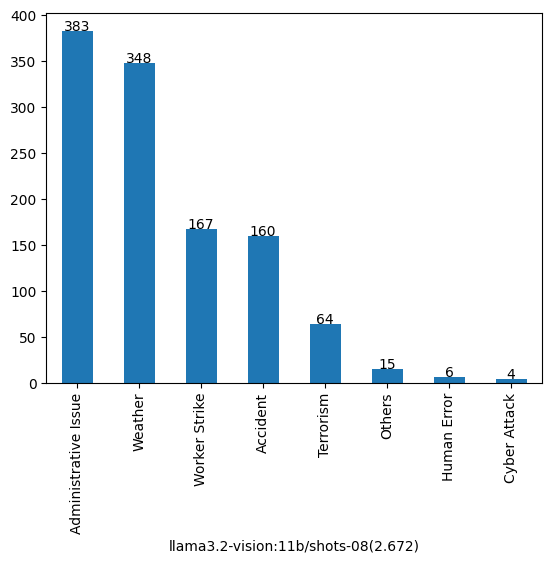

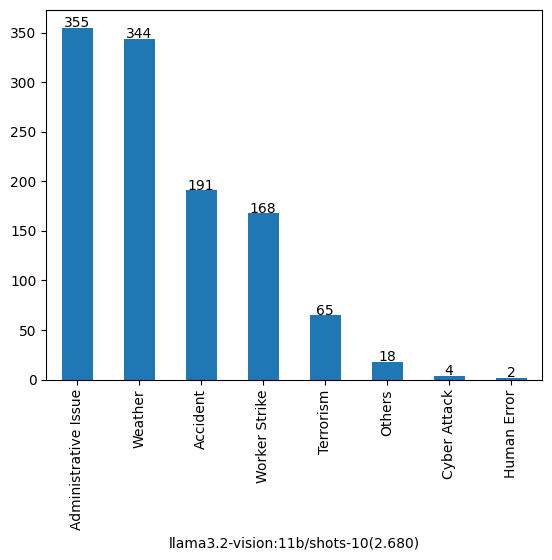

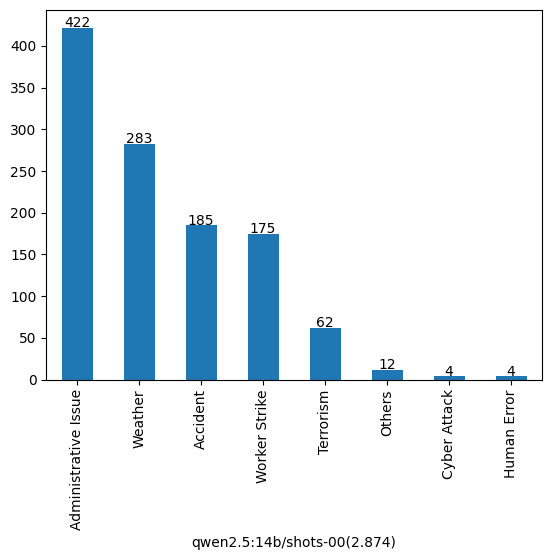

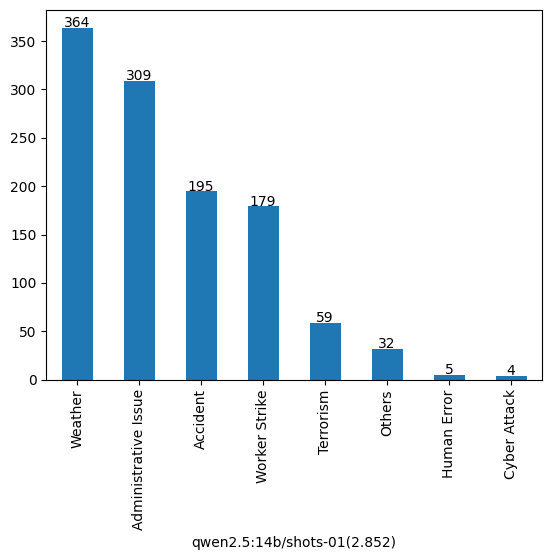

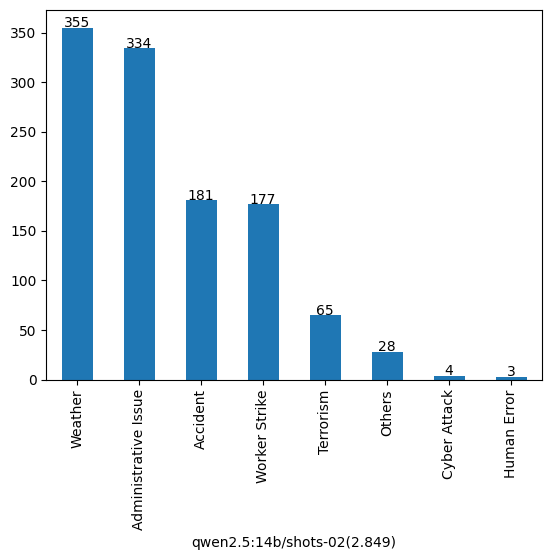

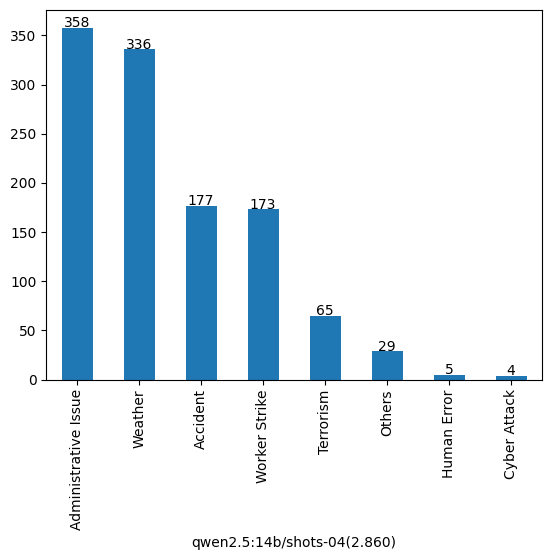

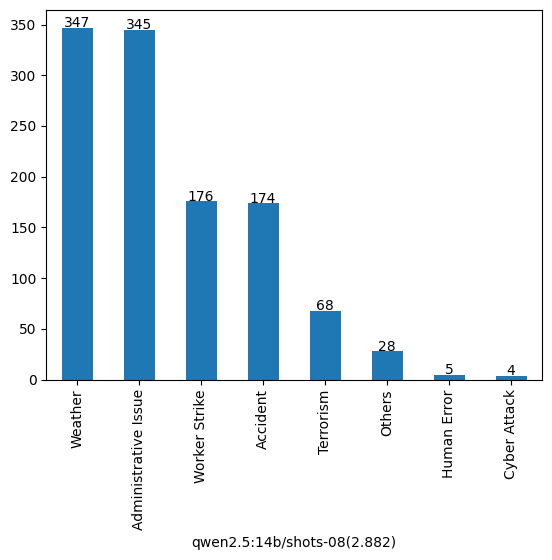

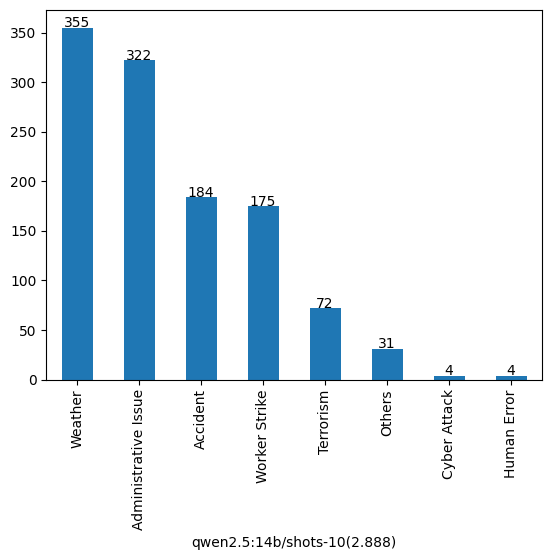

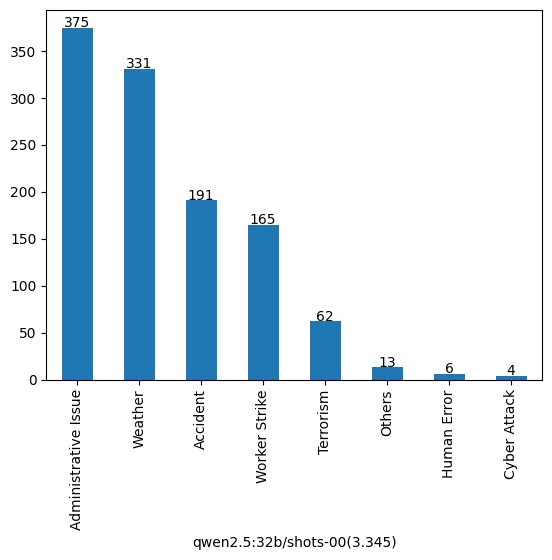

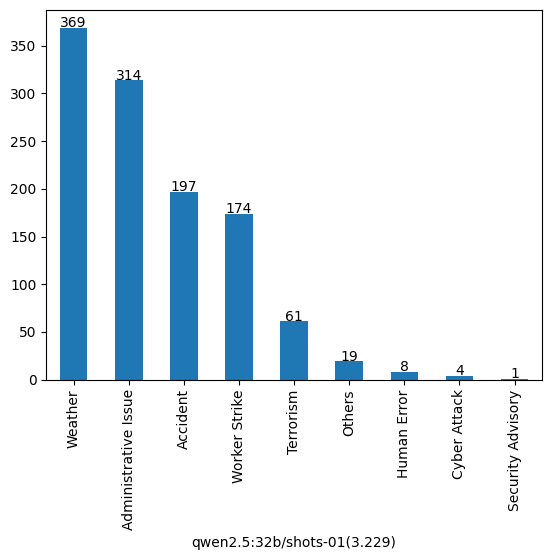

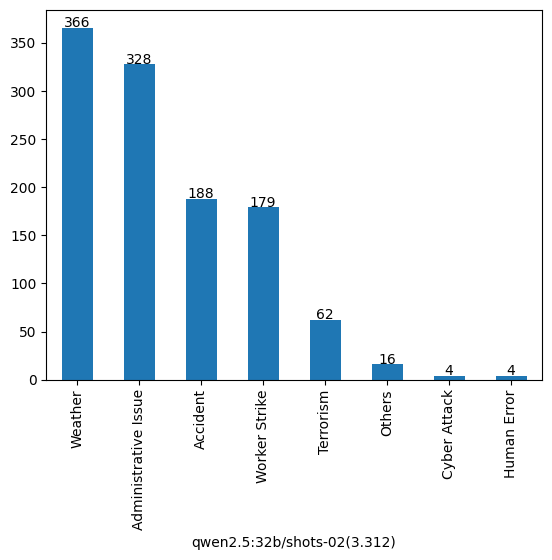

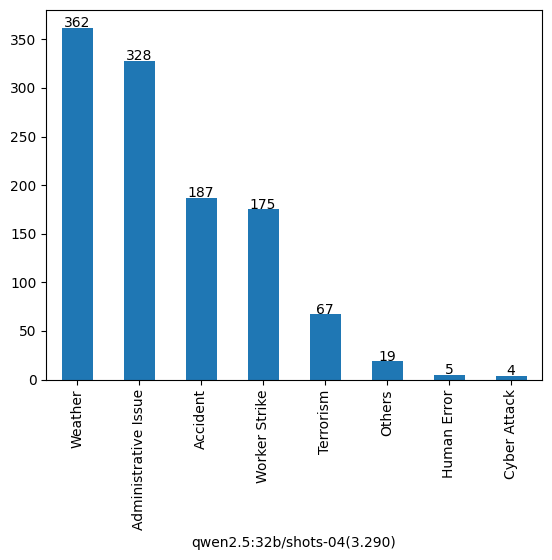

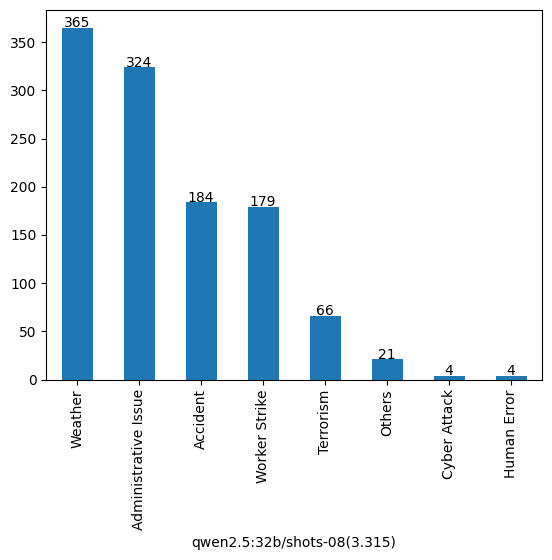

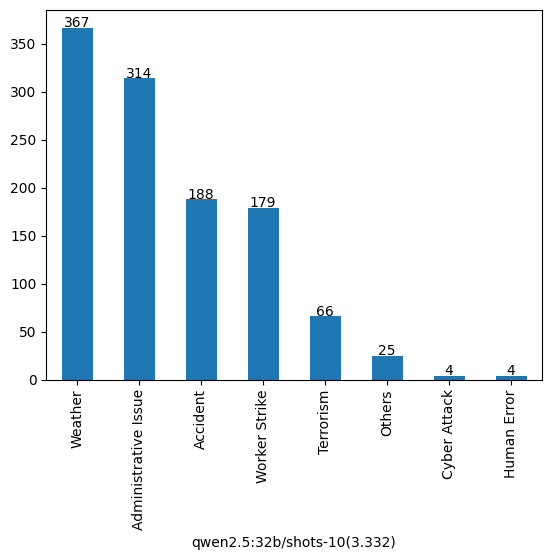

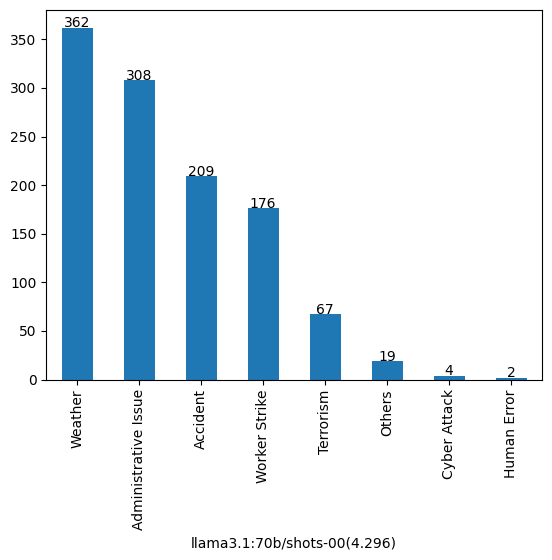

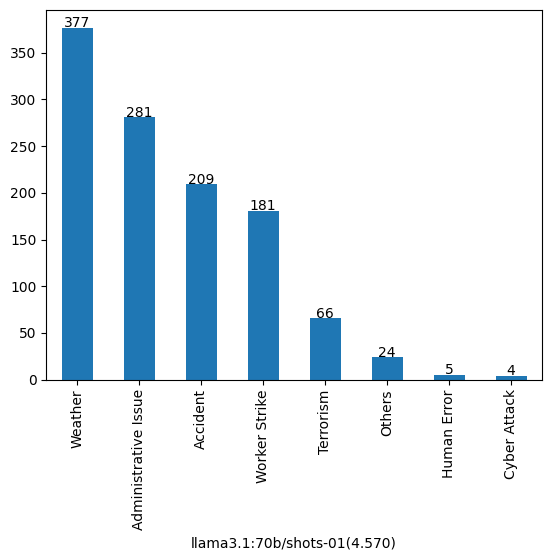

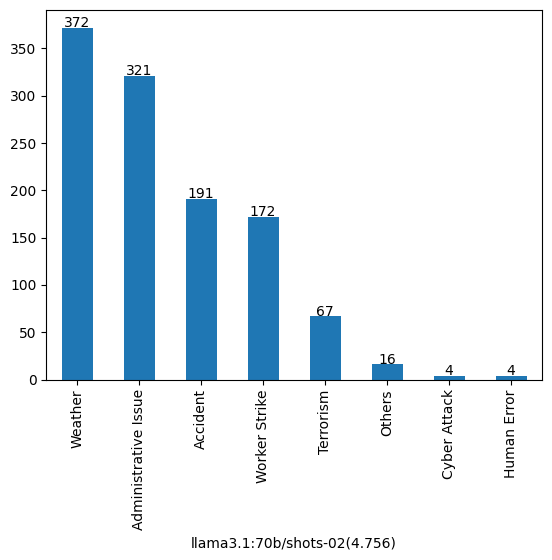

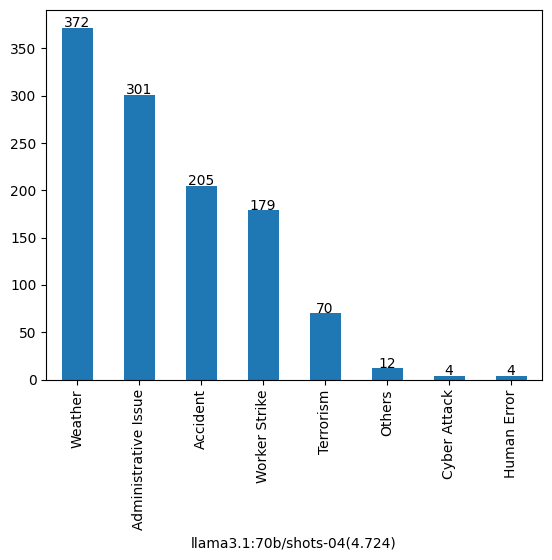

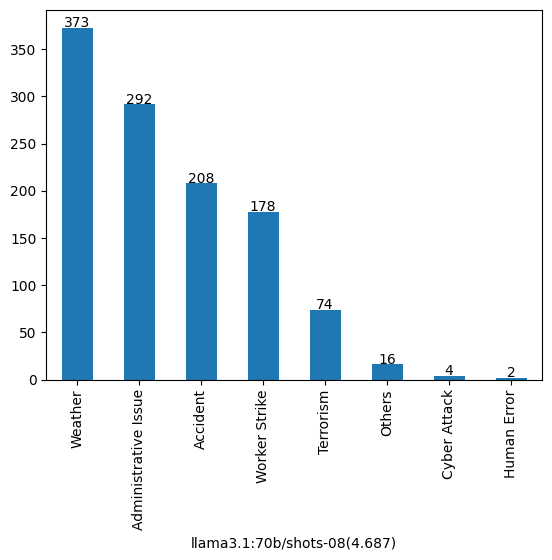

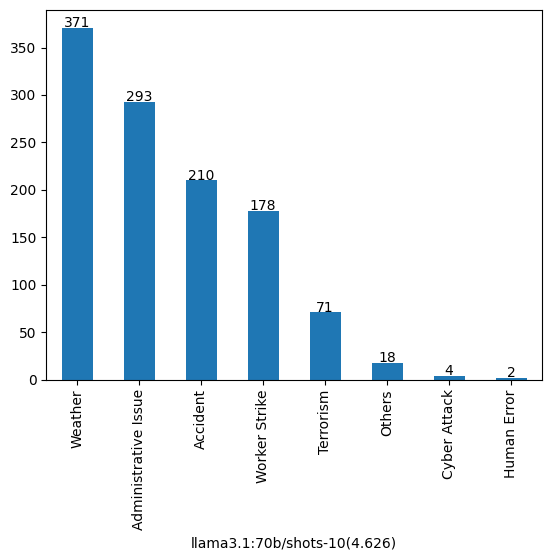

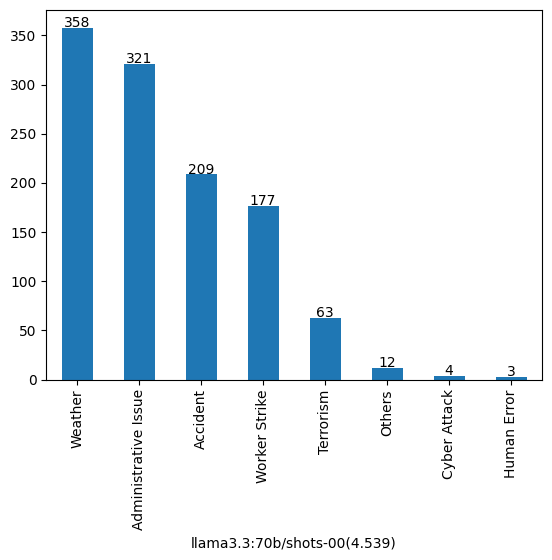

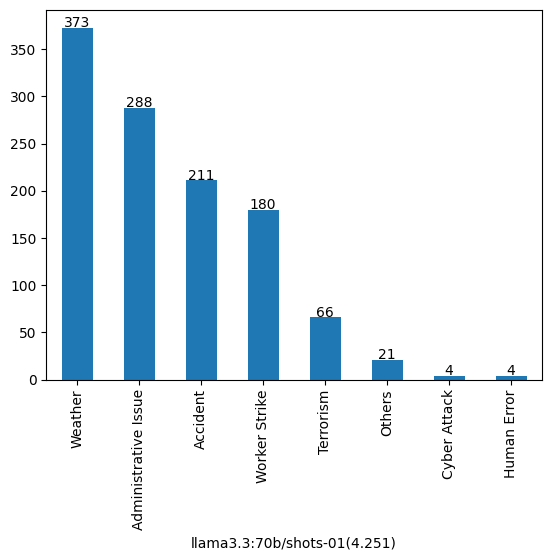

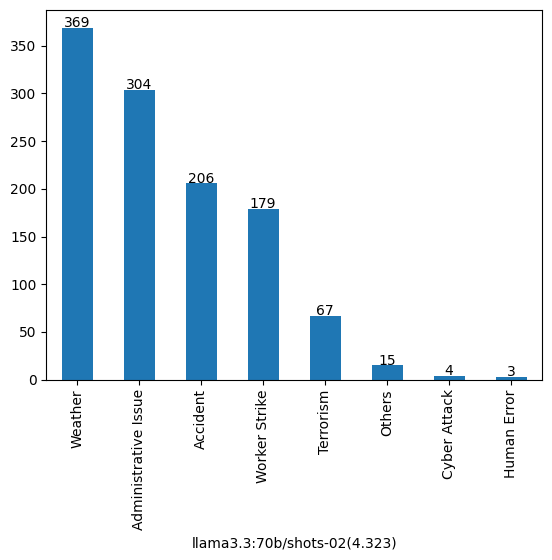

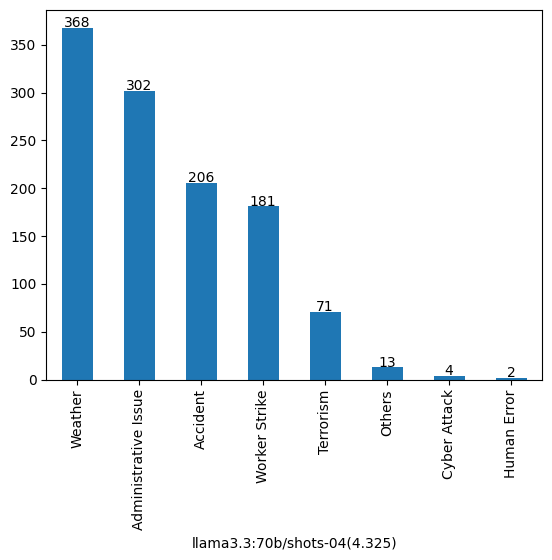

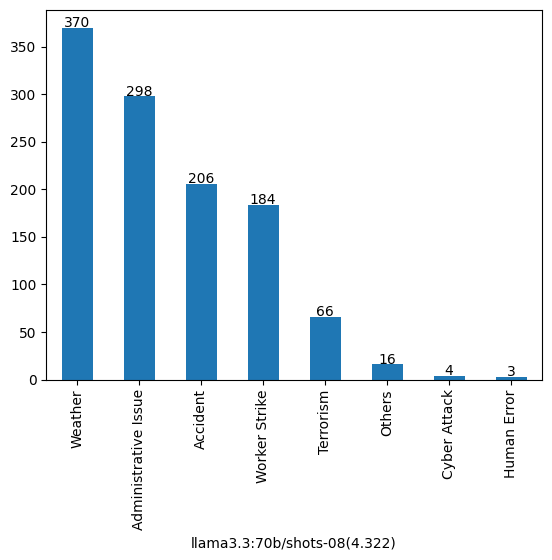

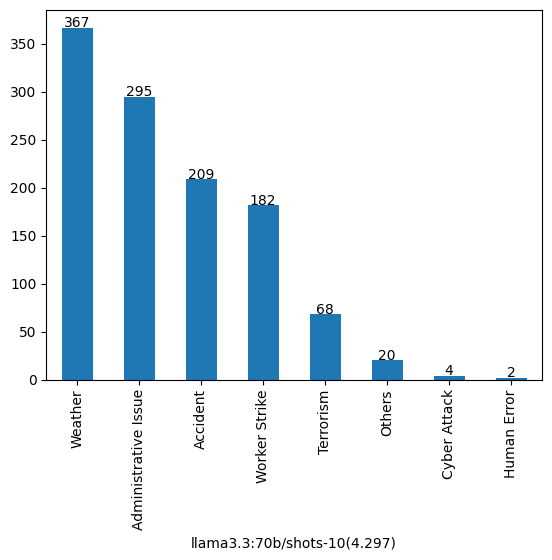

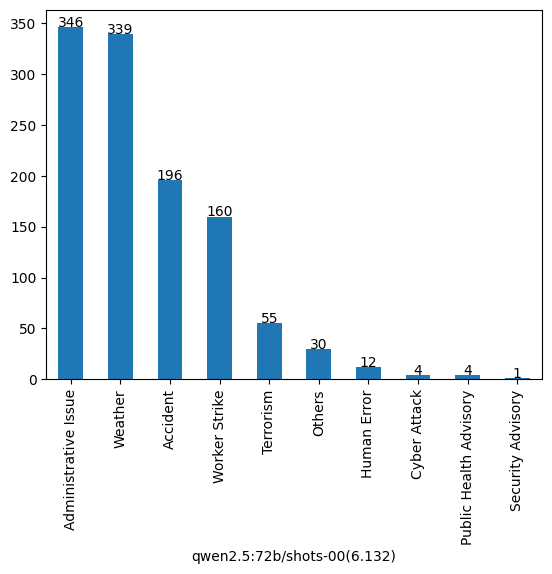

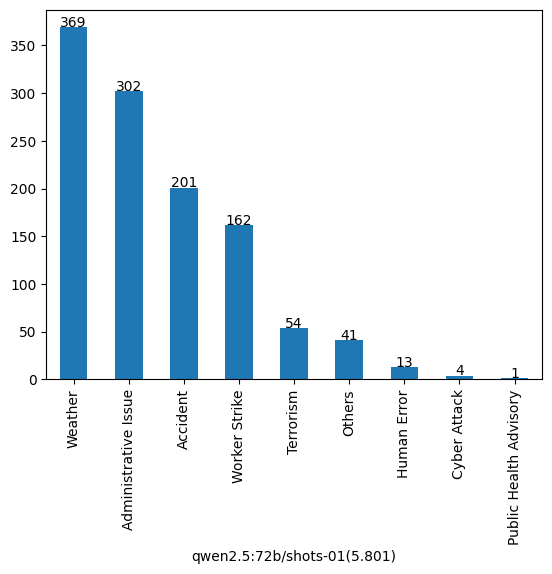

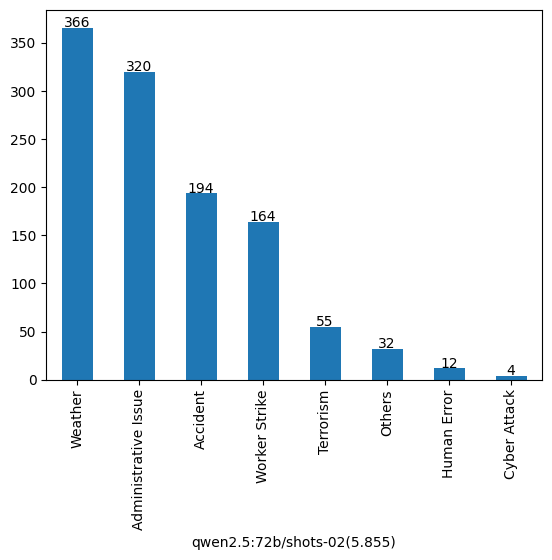

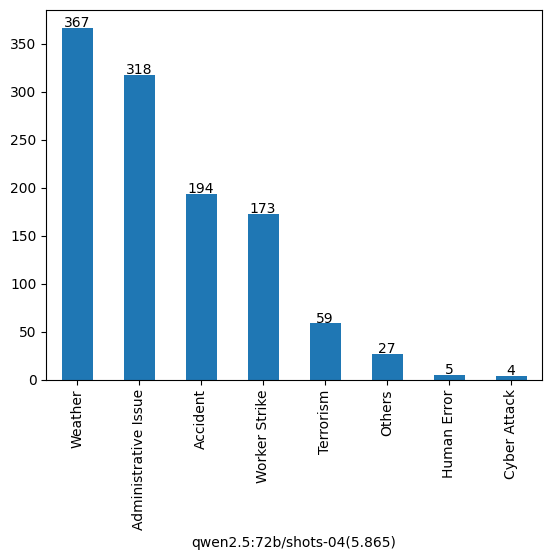

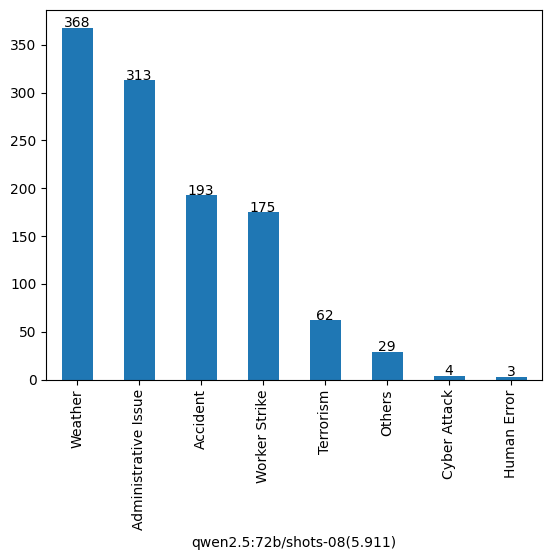

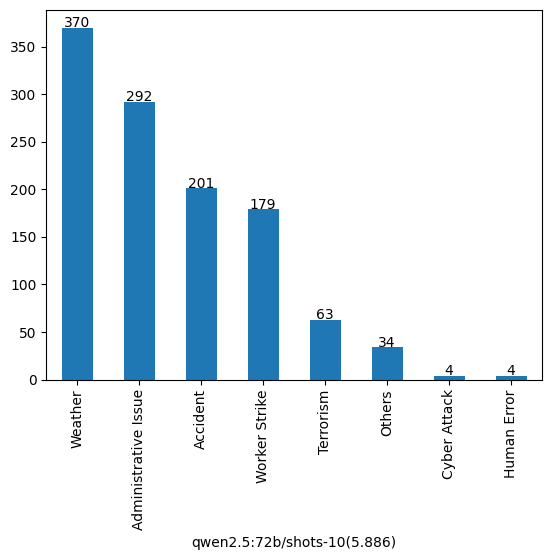

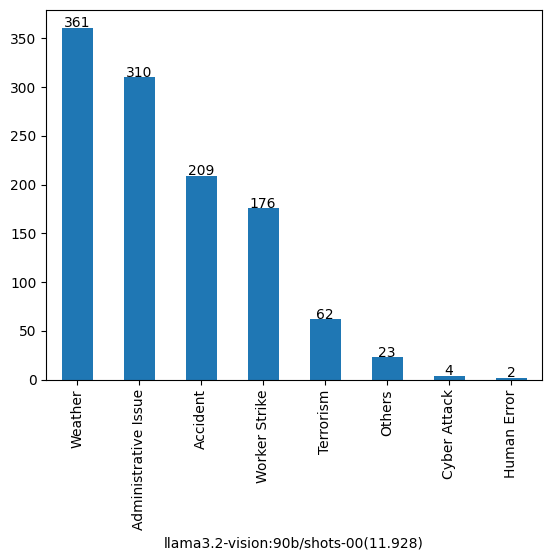

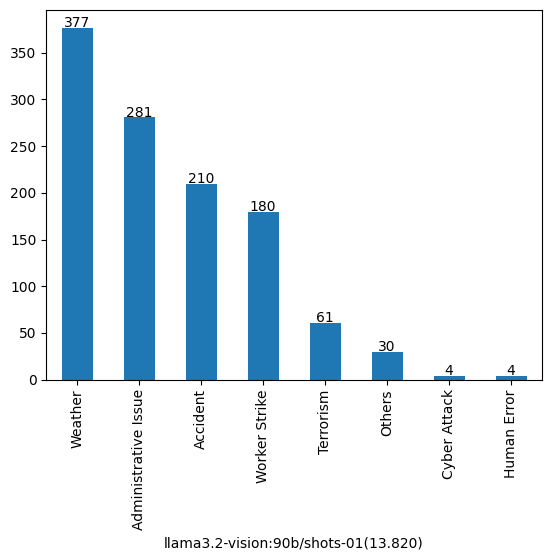

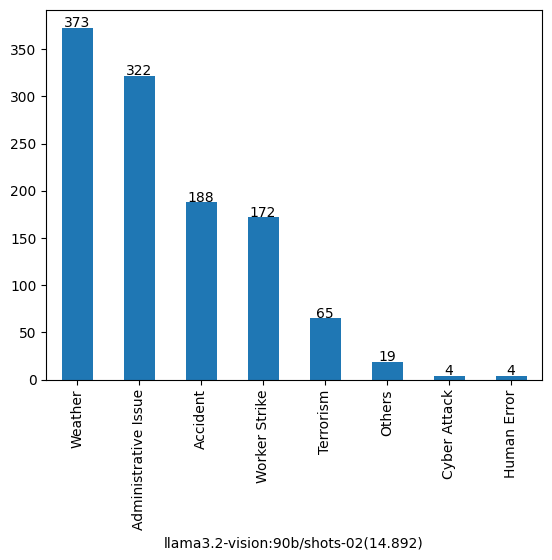

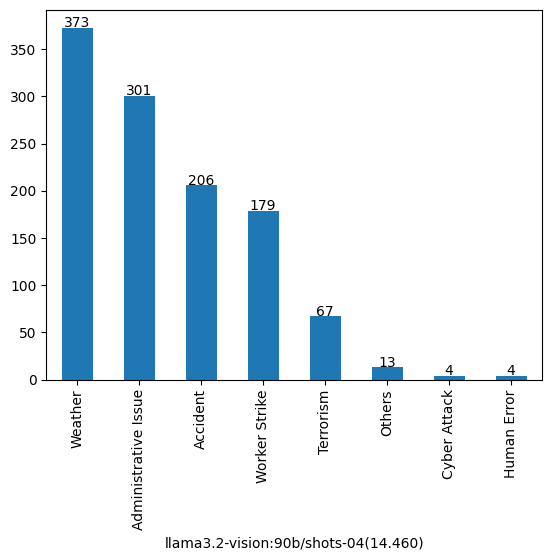

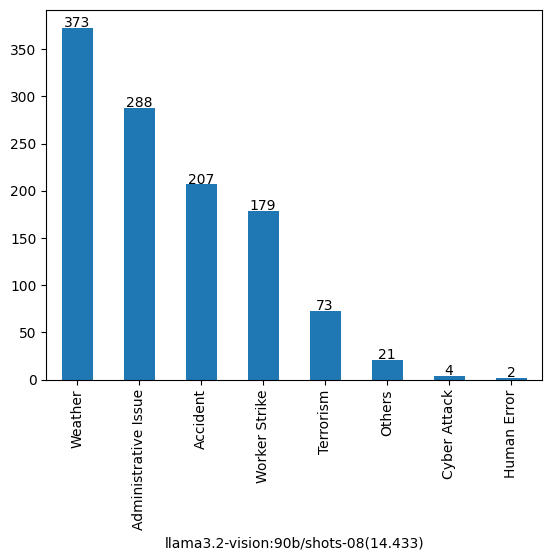

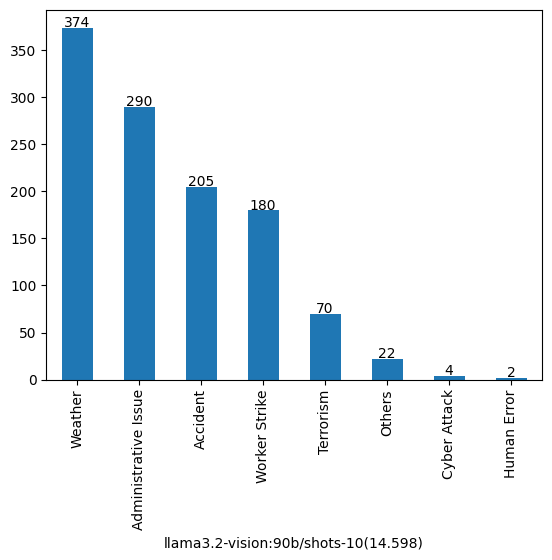

In [110]:
from llm_toolkit.data_utils import plot_bar_chart, extract_answer

for column in result_columns:
    plot_bar_chart(df, column, preprocess_func=extract_answer)